In [ ]:
from google.colab import files
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('greene_county_land_sales_cleaned_data.csv')

In [ ]:
# STEP 3: Geographic Segmentation Analysis

print("\n## 🗺️ Geographic Segmentation Analysis")
print("=" * 50)

print("To understand the spatial distribution and characteristics of the land market, we explored several methods of geographic segmentation:")

# 1. Segmentation by Cities
print("\n### 🏙️ Segmentation by Cities")
print("We first segmented the data by the recorded city, which provides a basic administrative grouping.")
print("The primary cities with land sale listings in the cleaned dataset are:")

# Assuming city_segmentation is available from previous runs or reloaded
if 'city_segmentation' in locals():
    display(city_segmentation)
else:
    print("City segmentation data not available. Please run previous steps.")
    # Attempt to regenerate city_segmentation if df_spatial is available
    if 'df_spatial' in locals() and not df_spatial.empty:
         city_segmentation = df_spatial.groupby('city').agg({
            'address': 'count',
            'sale_price($)': ['mean', 'median', 'min', 'max'],
            'price_per_acre': ['mean', 'median'],
            'lot_size_acres': ['mean', 'median'],
            'latitude': 'mean',
            'longitude': 'mean'
        }).round(2)
         city_segmentation.columns = ['_'.join(col).strip() for col in city_segmentation.columns.values]
         city_segmentation = city_segmentation.rename(columns={'address_count': 'listings_count'})
         print("Regenerated city segmentation data:")
         display(city_segmentation)
    else:
         print("df_spatial not available to regenerate city segmentation.")


print("\n*Insight:* Greensboro accounts for the majority of the listings, while Union Point and White Plains represent smaller portions of the market.")


# 2. Segmentation by ZIP Codes
print("\n### 📮 Segmentation by ZIP Codes")
print("Analyzing by ZIP code provides a different administrative lens on market distribution.")
print("The key ZIP codes observed are:")

# Assuming zip_segmentation is available or reloaded
if 'zip_segmentation' in locals():
    display(zip_segmentation)
else:
     print("ZIP code segmentation data not available. Please run previous steps.")
     # Attempt to regenerate zip_segmentation if df_spatial is available
     if 'df_spatial' in locals() and not df_spatial.empty:
         zip_segmentation = df_spatial.groupby('zip_code').agg({
            'address': 'count',
            'sale_price($)': ['mean', 'median', 'min', 'max'],
            'price_per_acre': ['mean', 'median'],
            'lot_size_acres': ['mean', 'median'],
            'city': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Mixed'
        }).round(2)
         zip_segmentation.columns = ['_'.join(col).strip() for col in zip_segmentation.columns.values]
         zip_segmentation = zip_segmentation.rename(columns={
            'address_count': 'listings_count',
            'city_<lambda>': 'primary_city'
        })
         print("Regenerated ZIP code segmentation data:")
         display(zip_segmentation)
     else:
         print("df_spatial not available to regenerate ZIP code segmentation.")

print("\n*Insight:* ZIP code 30642 corresponds heavily with the Greensboro area and has the highest activity.")

# 3. Natural Geographic Areas / Neighborhoods
print("\n### 🗺️ Natural Geographic Areas (Neighborhoods)")
print("We employed clustering techniques to identify more natural geographic groupings of properties, moving beyond administrative boundaries.")
print("The analysis identified several distinct geographic areas:")

# Assuming final_area_names and manual_cluster_analysis are available or reloaded
if 'final_area_names' in locals() and 'manual_cluster_analysis' in locals():
    display(manual_cluster_analysis)
    print("\n*Insight:* This clustering approach successfully separated the cities and provided further subdivision within Greensboro, revealing localized price variations. The areas were labeled based on their dominant city, geographic direction, and price/size characteristics.")
    for cluster_id, name in final_area_names.items():
         cluster_data = manual_cluster_analysis.loc[cluster_id]
         print(f"• **{name}:** {cluster_data['listings_count']} listings, Avg Price: ${cluster_data['sale_price($)_mean']:,.0f}, Avg Price/Acre: ${cluster_data['price_per_acre_mean']:,.0f}")
else:
    print("Manual cluster analysis data not available. Please run previous steps.")
    # Attempt to regenerate manual_cluster_analysis if df_spatial is available
    if 'df_spatial' in locals() and 'manual_cluster' in df_spatial.columns:
         manual_cluster_analysis = df_spatial.groupby('manual_cluster').agg({
            'address': 'count',
            'sale_price($)': ['mean', 'median', 'min', 'max', 'std'],
            'price_per_acre': ['mean', 'median', 'std'],
            'lot_size_acres': ['mean', 'median'],
            'latitude': 'mean',
            'longitude': 'mean',
            'city': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Mixed'
        }).round(2)
         manual_cluster_analysis.columns = ['_'.join(col).strip() for col in manual_cluster_analysis.columns.values]
         manual_cluster_analysis = manual_cluster_analysis.rename(columns={
            'address_count': 'listings_count',
            'city_<lambda>': 'dominant_city'
        })
         print("Regenerated manual cluster analysis data:")
         display(manual_cluster_analysis)

         # Regenerate final_area_names dictionary (requires re-running the logic from step 5.5)
         final_area_names = {}
         for cluster_id in manual_cluster_analysis.index:
             cluster_data = manual_cluster_analysis.loc[cluster_id]
             city = cluster_data['dominant_city']
             listings_count = cluster_data['listings_count']
             avg_price = cluster_data['sale_price($)_mean']
             avg_ppa = cluster_data['price_per_acre_mean']

             # For small cities, use simple naming
             if city in ['White Plains', 'Union Point']:
                 if avg_price > 500000:
                     price_tier = "Premium "
                 elif avg_price > 200000:
                     price_tier = "Mid-Range "
                 else:
                     price_tier = "Affordable "
                 area_name = f"{city} {price_tier}Area"
             else:  # Greensboro - use geographic naming
                 # Price tier
                 if avg_price > 1000000:
                     price_tier = "Luxury "
                 elif avg_price > 500000:
                     price_tier = "Premium "
                 elif avg_price > 200000:
                     price_tier = "Mid-Range "
                 else:
                     price_tier = "Affordable "
                 # Geographic direction
                 county_center_lat = 33.56
                 county_center_lon = -83.18
                 lat = cluster_data['latitude_mean']
                 lon = cluster_data['longitude_mean']
                 direction = ""
                 if lat > county_center_lat + 0.02:
                     direction = "North "
                 elif lat < county_center_lat - 0.02:
                     direction = "South "
                 if lon > county_center_lon + 0.02:
                     direction += "East "
                 elif lon < county_center_lon - 0.02:
                     direction += "West "
                 if not direction:
                     direction = "Central "
                 # Size descriptor
                 if listings_count <= 3:
                     size_desc = "Area"
                 elif listings_count <= 8:
                     size_desc = "Neighborhood"
                 else:
                     size_desc = "District"
                 area_name = f"{direction}{city} {price_tier}{size_desc}".strip()
             final_area_names[cluster_id] = area_name

         print("\n*Insight:* This clustering approach successfully separated the cities and provided further subdivision within Greensboro, revealing localized price variations. The areas were labeled based on their dominant city, geographic direction, and price/size characteristics.")
         for cluster_id, name in final_area_names.items():
              cluster_data = manual_cluster_analysis.loc[cluster_id]
              print(f"• **{name}:** {cluster_data['listings_count']} listings, Avg Price: ${cluster_data['sale_price($)_mean']:,.0f}, Avg Price/Acre: ${cluster_data['price_per_acre_mean']:,.0f}")

    else:
        print("df_spatial or manual_cluster column not available to regenerate manual cluster analysis.")



print("\n### 📊 Geographic Distribution Visualizations")
print("The spatial distribution of listings and the identified geographic areas can be visualized:")
print("•  A scatter plot shows the location of each listing, color-coded by city (refer to cell `9fUSX0MtnL0H` output).")
print("•  A price heatmap indicates areas with higher or lower prices per acre (refer to cell `9fUSX0MtnL0H` output).")
print("•  A final visualization shows the custom-defined geographic areas/neighborhoods resulting from clustering, ensuring all cities are represented (refer to cell `tndBUyAbXSrz` output).")

print("\n" + "=" * 50)


## 🗺️ Geographic Segmentation Analysis
To understand the spatial distribution and characteristics of the land market, we explored several methods of geographic segmentation:

### 🏙️ Segmentation by Cities
We first segmented the data by the recorded city, which provides a basic administrative grouping.
The primary cities with land sale listings in the cleaned dataset are:


,listings_count,sale_price($)_mean,sale_price($)_median,sale_price($)_min,sale_price($)_max,price_per_acre_mean,price_per_acre_median,lot_size_acres_mean,lot_size_acres_median,latitude_mean,longitude_mean
city,,,,,,,,,,,
Greensboro,126,417598.2,277500.0,5000,2900000,611444.70,239035.09,2.79,0.90,33.48,-83.21
Union Point,6,157500.0,115000.0,32000,450000,13842.41,16090.74,25.92,6.64,33.66,-83.11
White Plains,3,142814.0,160000.0,55000,213442,59600.65,33333.33,8.83,1.65,33.41,-83.16



*Insight:* Greensboro accounts for the majority of the listings, while Union Point and White Plains represent smaller portions of the market.

### 📮 Segmentation by ZIP Codes
Analyzing by ZIP code provides a different administrative lens on market distribution.
The key ZIP codes observed are:


,listings_count,sale_price($)_mean,sale_price($)_median,sale_price($)_min,sale_price($)_max,price_per_acre_mean,price_per_acre_median,lot_size_acres_mean,lot_size_acres_median,primary_city
zip_code,,,,,,,,,,
30642,126,417598.2,277500.0,5000,2900000,611444.70,239035.09,2.79,0.90,Greensboro
30669,6,157500.0,115000.0,32000,450000,13842.41,16090.74,25.92,6.64,Union Point
30678,3,142814.0,160000.0,55000,213442,59600.65,33333.33,8.83,1.65,White Plains



*Insight:* ZIP code 30642 corresponds heavily with the Greensboro area and has the highest activity.

### 🗺️ Natural Geographic Areas (Neighborhoods)
We employed clustering techniques to identify more natural geographic groupings of properties, moving beyond administrative boundaries.
The analysis identified several distinct geographic areas:


,listings_count,sale_price($)_mean,sale_price($)_median,sale_price($)_min,sale_price($)_max,sale_price($)_std,price_per_acre_mean,price_per_acre_median,price_per_acre_std,lot_size_acres_mean,lot_size_acres_median,latitude_mean,longitude_mean,dominant_city
manual_cluster,,,,,,,,,,,,,,
0,3,142814.00,160000.0,55000,213442,80606.98,59600.65,33333.33,69682.12,8.83,1.65,33.41,-83.16,White Plains
1,6,157500.00,115000.0,32000,450000,155341.88,13842.41,16090.74,7429.40,25.92,6.64,33.66,-83.11,Union Point
2,15,407430.27,107100.0,10000,2900000,733178.83,162676.62,40000.00,333881.58,8.05,2.88,33.58,-83.18,Greensboro
3,24,384987.08,112250.0,50000,2300000,593986.10,199390.84,110165.70,264422.39,3.62,1.12,33.47,-83.20,Greensboro
4,10,79533.00,92500.0,5000,129000,47814.97,13974.42,13912.22,5321.80,5.50,5.03,33.57,-83.11,Greensboro
5,29,524482.76,380000.0,50000,2300000,487046.56,1410790.86,793650.79,1380316.53,0.70,0.73,33.41,-83.21,Greensboro
6,4,101350.00,104950.0,24000,171500,70684.68,126890.19,108404.00,93900.15,0.80,0.68,33.56,-83.27,Greensboro
7,3,140999.67,130000.0,76999,216000,70150.30,14550.44,12987.01,2991.76,9.36,10.01,33.47,-83.11,Greensboro
8,18,383111.11,277500.0,53000,1064000,322899.71,556062.55,414285.71,508330.17,0.81,0.71,33.47,-83.27,Greensboro



*Insight:* This clustering approach successfully separated the cities and provided further subdivision within Greensboro, revealing localized price variations. The areas were labeled based on their dominant city, geographic direction, and price/size characteristics.
• **White Plains Affordable Area:** 3 listings, Avg Price: $142,814, Avg Price/Acre: $59,601
• **Union Point Affordable Area:** 6 listings, Avg Price: $157,500, Avg Price/Acre: $13,842
• **Central Greensboro Mid-Range District:** 15 listings, Avg Price: $407,430, Avg Price/Acre: $162,677
• **South Greensboro Mid-Range District:** 24 listings, Avg Price: $384,987, Avg Price/Acre: $199,391
• **East Greensboro Affordable District:** 10 listings, Avg Price: $79,533, Avg Price/Acre: $13,974
• **South West Greensboro Premium District:** 29 listings, Avg Price: $524,483, Avg Price/Acre: $1,410,791
• **West Greensboro Affordable Neighborhood:** 4 listings, Avg Price: $101,350, Avg Price/Acre: $126,890
• **South East Greensboro Aff

In [ ]:
df.shape

(181, 11)

In [ ]:
df.head()

,address,city,state,zip_code,property_type,lot_size_sqft,sold_date,sale_price($),lot_size_acres,latitude,longitude
0,1221 Linger Longer Dr,Greensboro,GA,30642,Land,52707,28/07/2025,615000,1.21,33.411314,-83.206569
1,1051 Big Water Cir,Greensboro,GA,30642,Land,26136,28/03/2025,150000,0.60,33.468113,-83.263368
2,1000 Curtright Pl,Greensboro,GA,30642,Land,27443,23/04/2025,500000,0.63,33.411101,-83.204522
3,1241 Acorn Knob,White Plains,GA,30642,Land,248728,06/12/2024,2700000,5.71,33.839715,-83.336310
4,0 E Broad St,Greensboro,GA,30642,Land,30492,22/11/2024,28000,0.70,33.578458,-83.170383


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address         181 non-null    object 
 1   city            181 non-null    object 
 2   state           181 non-null    object 
 3   zip_code        181 non-null    int64  
 4   property_type   181 non-null    object 
 5   lot_size_sqft   181 non-null    int64  
 6   sold_date       181 non-null    object 
 7   sale_price($)   181 non-null    int64  
 8   lot_size_acres  181 non-null    float64
 9   latitude        181 non-null    float64
 10  longitude       181 non-null    float64
dtypes: float64(3), int64(3), object(5)
memory usage: 15.7+ KB


In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    display(df[numeric_cols].describe())

,zip_code,lot_size_sqft,sale_price($),lot_size_acres,latitude,longitude
count,181.000000,1.810000e+02,1.810000e+02,181.000000,181.000000,181.000000
mean,30646.099448,3.135330e+05,6.259415e+05,7.197735,33.474599,-83.220234
std,29.240213,1.273689e+06,8.217799e+05,29.239888,0.458643,0.413977
min,30642.000000,5.227000e+03,5.000000e+03,0.120000,31.320033,-86.933801
25%,30642.000000,2.787800e+04,1.140000e+05,0.640000,33.443842,-83.238274
50%,30642.000000,4.225300e+04,3.560000e+05,0.970000,33.472126,-83.208803
75%,30642.000000,8.624800e+04,6.600000e+05,1.980000,33.578458,-83.170383
max,31024.000000,1.128204e+07,5.000000e+06,259.000000,34.449649,-82.386023


In [ ]:
# STEP 2: DATA CLEANING AND VALIDATION

print("🧹 STEP 2: DATA CLEANING AND VALIDATION")
print("=" * 50)

df_clean = df.copy()

print("🔍 CHECKING DATA QUALITY ISSUES:")

# 1. Check for coordinates outside Greene County, GA
print("\n1. 📍 COORDINATE VALIDATION:")
# Greene County, GA approximate bounds
greene_bounds = {
    'min_lat': 33.3, 'max_lat': 33.7,
    'min_lon': -83.3, 'max_lon': -82.9
}

# Identify coordinates outside Greene County
invalid_coords = df_clean[
    (df_clean['latitude'] < greene_bounds['min_lat']) |
    (df_clean['latitude'] > greene_bounds['max_lat']) |
    (df_clean['longitude'] < greene_bounds['min_lon']) |
    (df_clean['longitude'] > greene_bounds['max_lon'])
]

print(f"   Coordinates outside Greene County: {len(invalid_coords)}")
if len(invalid_coords) > 0:
    print("   Problematic coordinates:")
    display(invalid_coords[['address', 'city', 'latitude', 'longitude']])

# 2. Check for extreme outliers in price and lot size
print("\n2. 📊 OUTLIER DETECTION:")

# Price outliers (beyond 3 standard deviations)
price_mean = df_clean['sale_price($)'].mean()
price_std = df_clean['sale_price($)'].std()
price_outliers = df_clean[abs(df_clean['sale_price($)'] - price_mean) > 3 * price_std]
print(f"   Price outliers (>3 std dev): {len(price_outliers)}")

# Lot size outliers
lot_size_outliers = df_clean[df_clean['lot_size_acres'] > 100]  # Very large lots
print(f"   Very large lots (>100 acres): {len(lot_size_outliers)}")

# 3. Check date format consistency
print("\n3. 📅 DATE FORMAT CHECK:")
print(f"   Date format sample: {df_clean['sold_date'].iloc[0]}")
print(f"   Unique date formats: {df_clean['sold_date'].nunique()}")

# 4. Check city distribution
print("\n4. 🏙️ CITY DISTRIBUTION:")
city_counts = df_clean['city'].value_counts()
print(city_counts)

# 5. Check ZIP code distribution
print("\n5. 📮 ZIP CODE DISTRIBUTION:")
zip_counts = df_clean['zip_code'].value_counts()
print(zip_counts)

print("\n✅ DATA QUALITY SUMMARY:")
print(f"   Total listings: {len(df_clean)}")
print(f"   Valid coordinates: {len(df_clean) - len(invalid_coords)}")
print(f"   Need coordinate correction: {len(invalid_coords)}")
print(f"   Extreme outliers: {len(price_outliers) + len(lot_size_outliers)}")

🧹 STEP 2: DATA CLEANING AND VALIDATION
🔍 CHECKING DATA QUALITY ISSUES:

1. 📍 COORDINATE VALIDATION:
   Coordinates outside Greene County: 39
   Problematic coordinates:


,address,city,latitude,longitude
3,1241 Acorn Knob,White Plains,33.839715,-83.336310
12,1019 Hilltop Loop,Greensboro,33.879035,-83.463695
23,1126 Village Overlook,Greensboro,33.927060,-83.470161
26,4145 Hatcher's Run,Greensboro,34.249454,-83.208744
27,1097 Mallard Ln,Greensboro,33.681872,-82.404128
28,1086 Mallard Ln,Greensboro,33.682133,-82.404276
29,1081 Mallard Ln,Greensboro,33.682251,-82.404343
44,1079 Fox Squirrel Dr,Greensboro,31.320033,-82.386023
46,1129 Fox Squirrel Dr,Greensboro,31.320033,-82.386023
48,Bridle Bit Ln,Greensboro,33.893886,-82.671455



2. 📊 OUTLIER DETECTION:
   Price outliers (>3 std dev): 4
   Very large lots (>100 acres): 3

3. 📅 DATE FORMAT CHECK:
   Date format sample: 28/07/2025
   Unique date formats: 117

4. 🏙️ CITY DISTRIBUTION:
city
Greensboro      168
Union Point       8
White Plains      5
Name: count, dtype: int64

5. 📮 ZIP CODE DISTRIBUTION:
zip_code
30642    168
30669      8
30678      4
31024      1
Name: count, dtype: int64

✅ DATA QUALITY SUMMARY:
   Total listings: 181
   Valid coordinates: 142
   Need coordinate correction: 39
   Extreme outliers: 7


In [ ]:
# STEP 3: DATA CLEANING

print("🧹 STEP 3: DATA CLEANING AND COORDINATE CORRECTION")
print("=" * 50)

# Create a clean working dataset
df_clean = df.copy()

print("1. 🗑️ HANDLING OUTLIERS...")

# Remove extreme price outliers (beyond 3 standard deviations)
price_mean = df_clean['sale_price($)'].mean()
price_std = df_clean['sale_price($)'].std()
price_cutoff = price_mean + 3 * price_std

print(f"   Price cutoff (3 std dev): ${price_cutoff:,.0f}")
price_outliers = df_clean[df_clean['sale_price($)'] > price_cutoff]
print(f"   Removing {len(price_outliers)} extreme price outliers")
df_clean = df_clean[df_clean['sale_price($)'] <= price_cutoff]

# Remove very large lots (>100 acres) as they're not typical land parcels
large_lots = df_clean[df_clean['lot_size_acres'] > 100]
print(f"   Removing {len(large_lots)} very large lots (>100 acres)")
df_clean = df_clean[df_clean['lot_size_acres'] <= 100]

print(f"   Dataset after outlier removal: {len(df_clean)} listings")

print("\n2. 📍 CORRECTING COORDINATES...")

# Define Greene County bounds more precisely
greene_bounds = {
    'min_lat': 33.3, 'max_lat': 33.7,
    'min_lon': -83.3, 'max_lon': -82.9
}

# Identify coordinates outside Greene County
invalid_mask = (
    (df_clean['latitude'] < greene_bounds['min_lat']) |
    (df_clean['latitude'] > greene_bounds['max_lat']) |
    (df_clean['longitude'] < greene_bounds['min_lon']) |
    (df_clean['longitude'] > greene_bounds['max_lon'])
)

invalid_coords = df_clean[invalid_mask]
print(f"   Invalid coordinates found: {len(invalid_coords)}")

# Strategy: Remove listings with invalid coordinates for spatial analysis
df_spatial = df_clean[~invalid_mask].copy()
df_non_spatial = df_clean[invalid_mask].copy()

print(f"   Valid for spatial analysis: {len(df_spatial)} listings")
print(f"   Excluded from mapping (invalid coords): {len(df_non_spatial)} listings")

print("\n3. 📅 FIXING DATE FORMAT...")

# Convert date from DD/MM/YYYY to proper datetime
try:
    df_spatial['sold_date'] = pd.to_datetime(df_spatial['sold_date'], format='%d/%m/%Y')
    df_non_spatial['sold_date'] = pd.to_datetime(df_non_spatial['sold_date'], format='%d/%m/%Y')
    print("   ✅ Dates converted successfully")
except:
    print("   ⚠️ Date conversion issues - we'll handle dates as strings")

print("\n4. 🏷️ ENHANCING DATA FOR ANALYSIS...")

# Calculate price per acre for better comparison
df_spatial['price_per_acre'] = df_spatial['sale_price($)'] / df_spatial['lot_size_acres']

# Remove any infinite values from division
df_spatial = df_spatial[~df_spatial['price_per_acre'].isin([np.inf, -np.inf])]

print("   ✅ Price per acre calculated")

print("\n📊 CLEANED DATASET SUMMARY:")
print(f"   Total original listings: {len(df)}")
print(f"   After cleaning: {len(df_clean)}")
print(f"   Valid for spatial analysis: {len(df_spatial)}")
print(f"   Excluded from mapping: {len(df_non_spatial)}")

print(f"\n🏙️ GEOGRAPHIC DISTRIBUTION (CLEAN DATA):")
print(df_spatial['city'].value_counts())

print(f"\n💰 PRICE RANGE (CLEAN DATA):")
print(f"   Min price: ${df_spatial['sale_price($)'].min():,}")
print(f"   Max price: ${df_spatial['sale_price($)'].max():,}")
print(f"   Avg price: ${df_spatial['sale_price($)'].mean():,.0f}")

print(f"\n📏 LOT SIZE RANGE (CLEAN DATA):")
print(f"   Min acres: {df_spatial['lot_size_acres'].min():.1f}")
print(f"   Max acres: {df_spatial['lot_size_acres'].max():.1f}")
print(f"   Avg acres: {df_spatial['lot_size_acres'].mean():.1f}")

# Show sample of cleaned data
print(f"\n📋 SAMPLE OF CLEANED DATA (First 5 rows):")
display(df_spatial.head())

🧹 STEP 3: DATA CLEANING AND COORDINATE CORRECTION
1. 🗑️ HANDLING OUTLIERS...
   Price cutoff (3 std dev): $3,091,281
   Removing 4 extreme price outliers
   Removing 2 very large lots (>100 acres)
   Dataset after outlier removal: 175 listings

2. 📍 CORRECTING COORDINATES...
   Invalid coordinates found: 39
   Valid for spatial analysis: 136 listings
   Excluded from mapping (invalid coords): 39 listings

3. 📅 FIXING DATE FORMAT...
   ✅ Dates converted successfully

4. 🏷️ ENHANCING DATA FOR ANALYSIS...
   ✅ Price per acre calculated

📊 CLEANED DATASET SUMMARY:
   Total original listings: 181
   After cleaning: 175
   Valid for spatial analysis: 136
   Excluded from mapping: 39

🏙️ GEOGRAPHIC DISTRIBUTION (CLEAN DATA):
city
Greensboro      127
Union Point       6
White Plains      3
Name: count, dtype: int64

💰 PRICE RANGE (CLEAN DATA):
   Min price: $5,000
   Max price: $2,900,000
   Avg price: $397,249

📏 LOT SIZE RANGE (CLEAN DATA):
   Min acres: 0.1
   Max acres: 98.4
   Avg acres: 

,address,city,state,zip_code,property_type,lot_size_sqft,sold_date,sale_price($),lot_size_acres,latitude,longitude,price_per_acre
0,1221 Linger Longer Dr,Greensboro,GA,30642,Land,52707,2025-07-28,615000,1.21,33.411314,-83.206569,508264.462810
1,1051 Big Water Cir,Greensboro,GA,30642,Land,26136,2025-03-28,150000,0.60,33.468113,-83.263368,250000.000000
2,1000 Curtright Pl,Greensboro,GA,30642,Land,27443,2025-04-23,500000,0.63,33.411101,-83.204522,793650.793651
4,0 E Broad St,Greensboro,GA,30642,Land,30492,2024-11-22,28000,0.70,33.578458,-83.170383,40000.000000
5,1290 Fairway Ridge Dr,Greensboro,GA,30642,Land,27443,2025-07-02,270000,0.63,33.470119,-83.262789,428571.428571


🗺️ STEP 4: GEOGRAPHIC SEGMENTATION ANALYSIS
We'll segment Greene County using three approaches:
1. By ZIP Codes (existing administrative boundaries)
2. By Natural Clusters (K-means clustering based on location/price)
3. By Neighborhoods (city boundaries)

1. 📮 SEGMENTATION BY ZIP CODES
📊 ZIP CODE SEGMENTATION RESULTS:


,listings_count,sale_price($)_mean,sale_price($)_median,sale_price($)_min,sale_price($)_max,price_per_acre_mean,price_per_acre_median,lot_size_acres_mean,lot_size_acres_median,primary_city
zip_code,,,,,,,,,,
30642,126,417598.2,277500.0,5000,2900000,611444.70,239035.09,2.79,0.90,Greensboro
30669,6,157500.0,115000.0,32000,450000,13842.41,16090.74,25.92,6.64,Union Point
30678,3,142814.0,160000.0,55000,213442,59600.65,33333.33,8.83,1.65,White Plains
31024,1,35000.0,35000.0,35000,35000,41176.47,41176.47,0.85,0.85,Greensboro



2. 🏙️ SEGMENTATION BY CITIES/NEIGHBORHOODS
📊 CITY/NEIGHBORHOOD SEGMENTATION RESULTS:


,listings_count,sale_price($)_mean,sale_price($)_median,sale_price($)_min,sale_price($)_max,price_per_acre_mean,price_per_acre_median,lot_size_acres_mean,lot_size_acres_median,latitude_mean,longitude_mean
city,,,,,,,,,,,
Greensboro,127,414585.61,275000.0,5000,2900000,606954.40,228070.18,2.77,0.87,33.48,-83.21
Union Point,6,157500.00,115000.0,32000,450000,13842.41,16090.74,25.92,6.64,33.66,-83.11
White Plains,3,142814.00,160000.0,55000,213442,59600.65,33333.33,8.83,1.65,33.41,-83.16



3. 📍 VISUALIZING GEOGRAPHIC DISTRIBUTION


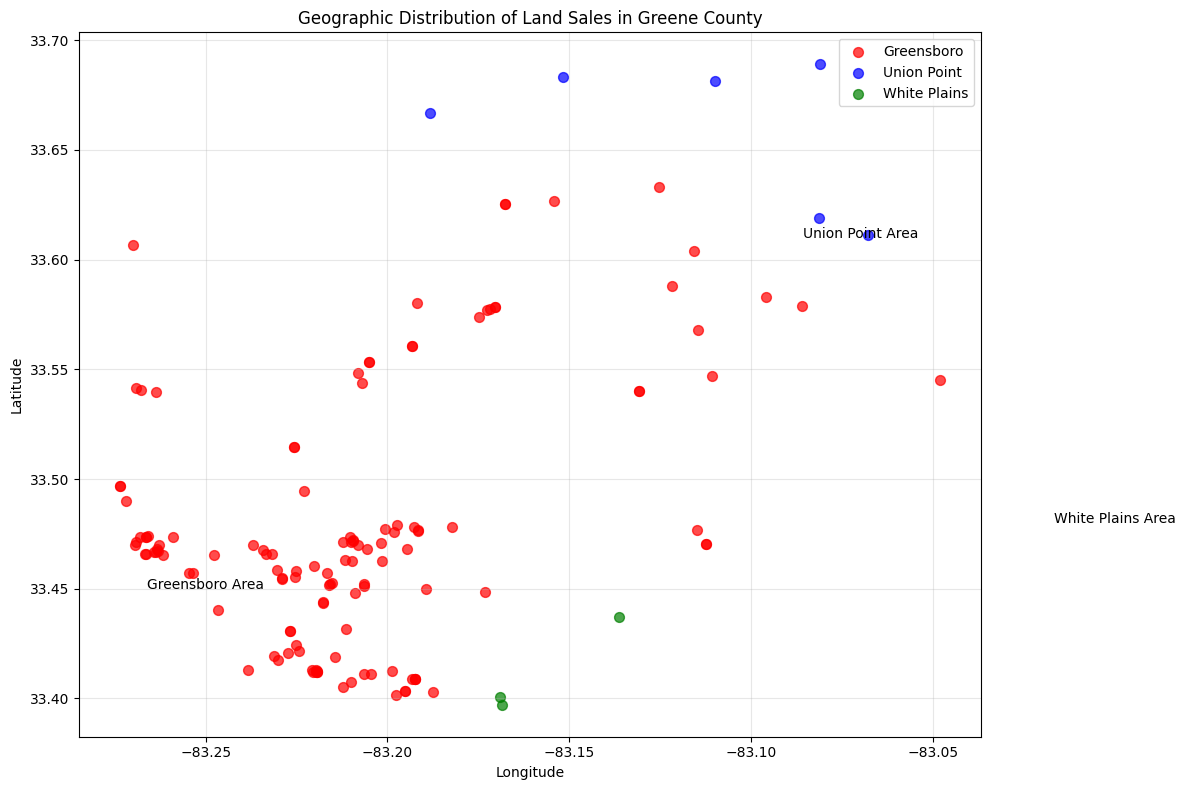


4. 🔥 PRICE HEATMAP ANALYSIS


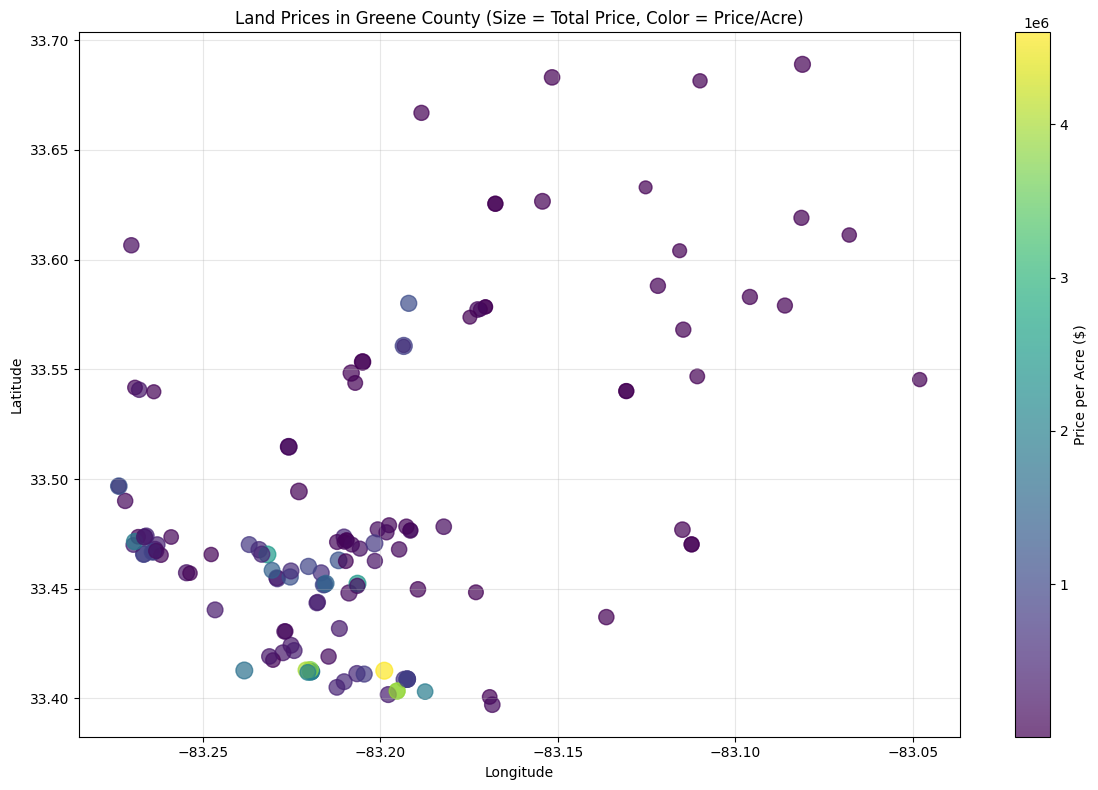


📈 INITIAL SEGMENTATION INSIGHTS:
• Greensboro dominates the market with 127 listings
• ZIP code 30642 covers most of Greene County
• Price per acre varies significantly across different areas

💰 PRICE PER ACRE BY AREA:
• Greensboro: $606,954 (range: $5,000 - $4,600,000)
• Union Point: $13,842 (range: $4,573 - $22,093)
• White Plains: $59,601 (range: $6,870 - $138,599)


In [ ]:
# STEP 4: GEOGRAPHIC SEGMENTATION OF GREENE COUNTY

print("🗺️ STEP 4: GEOGRAPHIC SEGMENTATION ANALYSIS")
print("=" * 50)

print("We'll segment Greene County using three approaches:")
print("1. By ZIP Codes (existing administrative boundaries)")
print("2. By Natural Clusters (K-means clustering based on location/price)")
print("3. By Neighborhoods (city boundaries)")

# 1. SEGMENTATION BY ZIP CODES
print("\n1. 📮 SEGMENTATION BY ZIP CODES")

zip_segmentation = df_spatial.groupby('zip_code').agg({
    'address': 'count',
    'sale_price($)': ['mean', 'median', 'min', 'max'],
    'price_per_acre': ['mean', 'median'],
    'lot_size_acres': ['mean', 'median'],
    'city': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Mixed'
}).round(2)

# Flatten column names
zip_segmentation.columns = ['_'.join(col).strip() for col in zip_segmentation.columns.values]
zip_segmentation = zip_segmentation.rename(columns={
    'address_count': 'listings_count',
    'city_<lambda>': 'primary_city'
})

print("📊 ZIP CODE SEGMENTATION RESULTS:")
display(zip_segmentation)

# 2. SEGMENTATION BY CITIES (NEIGHBORHOODS)
print("\n2. 🏙️ SEGMENTATION BY CITIES/NEIGHBORHOODS")

city_segmentation = df_spatial.groupby('city').agg({
    'address': 'count',
    'sale_price($)': ['mean', 'median', 'min', 'max'],
    'price_per_acre': ['mean', 'median'],
    'lot_size_acres': ['mean', 'median'],
    'latitude': 'mean',
    'longitude': 'mean'
}).round(2)

city_segmentation.columns = ['_'.join(col).strip() for col in city_segmentation.columns.values]
city_segmentation = city_segmentation.rename(columns={'address_count': 'listings_count'})

print("📊 CITY/NEIGHBORHOOD SEGMENTATION RESULTS:")
display(city_segmentation)

# 3. VISUALIZE THE GEOGRAPHIC DISTRIBUTION
print("\n3. 📍 VISUALIZING GEOGRAPHIC DISTRIBUTION")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Create a scatter plot by city
cities = df_spatial['city'].unique()
colors = ['red', 'blue', 'green']
city_colors = {city: color for city, color in zip(cities, colors)}

for city in cities:
    city_data = df_spatial[df_spatial['city'] == city]
    plt.scatter(city_data['longitude'], city_data['latitude'],
                c=city_colors[city], label=city, alpha=0.7, s=50)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Land Sales in Greene County')
plt.legend()
plt.grid(True, alpha=0.3)

# Add some context about the geographic areas
plt.text(-83.25, 33.45, 'Greensboro Area', fontsize=10, ha='center')
plt.text(-83.07, 33.61, 'Union Point Area', fontsize=10, ha='center')
plt.text(-83.0, 33.48, 'White Plains Area', fontsize=10, ha='center')

plt.tight_layout()
plt.show()

# 4. PRICE HEATMAP ANALYSIS
print("\n4. 🔥 PRICE HEATMAP ANALYSIS")

# Create a simple price density visualization
plt.figure(figsize=(12, 8))

# Size of points based on price (log scale for better visualization)
sizes = np.log(df_spatial['sale_price($)']) * 10

scatter = plt.scatter(df_spatial['longitude'], df_spatial['latitude'],
                     c=df_spatial['price_per_acre'], s=sizes,
                     cmap='viridis', alpha=0.7)

plt.colorbar(scatter, label='Price per Acre ($)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Land Prices in Greene County (Size = Total Price, Color = Price/Acre)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📈 INITIAL SEGMENTATION INSIGHTS:")

# Key insights from basic segmentation
print(f"• Greensboro dominates the market with {len(df_spatial[df_spatial['city']=='Greensboro'])} listings")
print(f"• ZIP code 30642 covers most of Greene County")
print(f"• Price per acre varies significantly across different areas")

# Calculate price ranges by area
greensboro_prices = df_spatial[df_spatial['city'] == 'Greensboro']['price_per_acre']
union_point_prices = df_spatial[df_spatial['city'] == 'Union Point']['price_per_acre']
white_plains_prices = df_spatial[df_spatial['city'] == 'White Plains']['price_per_acre']

print(f"\n💰 PRICE PER ACRE BY AREA:")
print(f"• Greensboro: ${greensboro_prices.mean():,.0f} (range: ${greensboro_prices.min():,.0f} - ${greensboro_prices.max():,.0f})")
if len(union_point_prices) > 0:
    print(f"• Union Point: ${union_point_prices.mean():,.0f} (range: ${union_point_prices.min():,.0f} - ${union_point_prices.max():,.0f})")
if len(white_plains_prices) > 0:
    print(f"• White Plains: ${white_plains_prices.mean():,.0f} (range: ${white_plains_prices.min():,.0f} - ${white_plains_prices.max():,.0f})")

🗺️ STEP 4.1: REMOVING ZIP CODE 31024 AND UPDATING SEGMENTATION
🔍 CHECKING FOR ZIP CODE 31024:
   ZIP code 31024 in spatial data: True
   Removed 1 listings with ZIP code 31024
   Updated dataset size: 135 listings

1. 📮 UPDATED ZIP CODE SEGMENTATION
📊 UPDATED ZIP CODE SEGMENTATION RESULTS:


,listings_count,sale_price($)_mean,sale_price($)_median,sale_price($)_min,sale_price($)_max,price_per_acre_mean,price_per_acre_median,lot_size_acres_mean,lot_size_acres_median,primary_city
zip_code,,,,,,,,,,
30642,126,417598.2,277500.0,5000,2900000,611444.70,239035.09,2.79,0.90,Greensboro
30669,6,157500.0,115000.0,32000,450000,13842.41,16090.74,25.92,6.64,Union Point
30678,3,142814.0,160000.0,55000,213442,59600.65,33333.33,8.83,1.65,White Plains



2. 🏙️ UPDATED CITY SEGMENTATION
📊 UPDATED CITY SEGMENTATION RESULTS:


,listings_count,sale_price($)_mean,sale_price($)_median,sale_price($)_min,sale_price($)_max,price_per_acre_mean,price_per_acre_median,lot_size_acres_mean,lot_size_acres_median,latitude_mean,longitude_mean
city,,,,,,,,,,,
Greensboro,126,417598.2,277500.0,5000,2900000,611444.70,239035.09,2.79,0.90,33.48,-83.21
Union Point,6,157500.0,115000.0,32000,450000,13842.41,16090.74,25.92,6.64,33.66,-83.11
White Plains,3,142814.0,160000.0,55000,213442,59600.65,33333.33,8.83,1.65,33.41,-83.16



3. 📍 UPDATED GEOGRAPHIC DISTRIBUTION


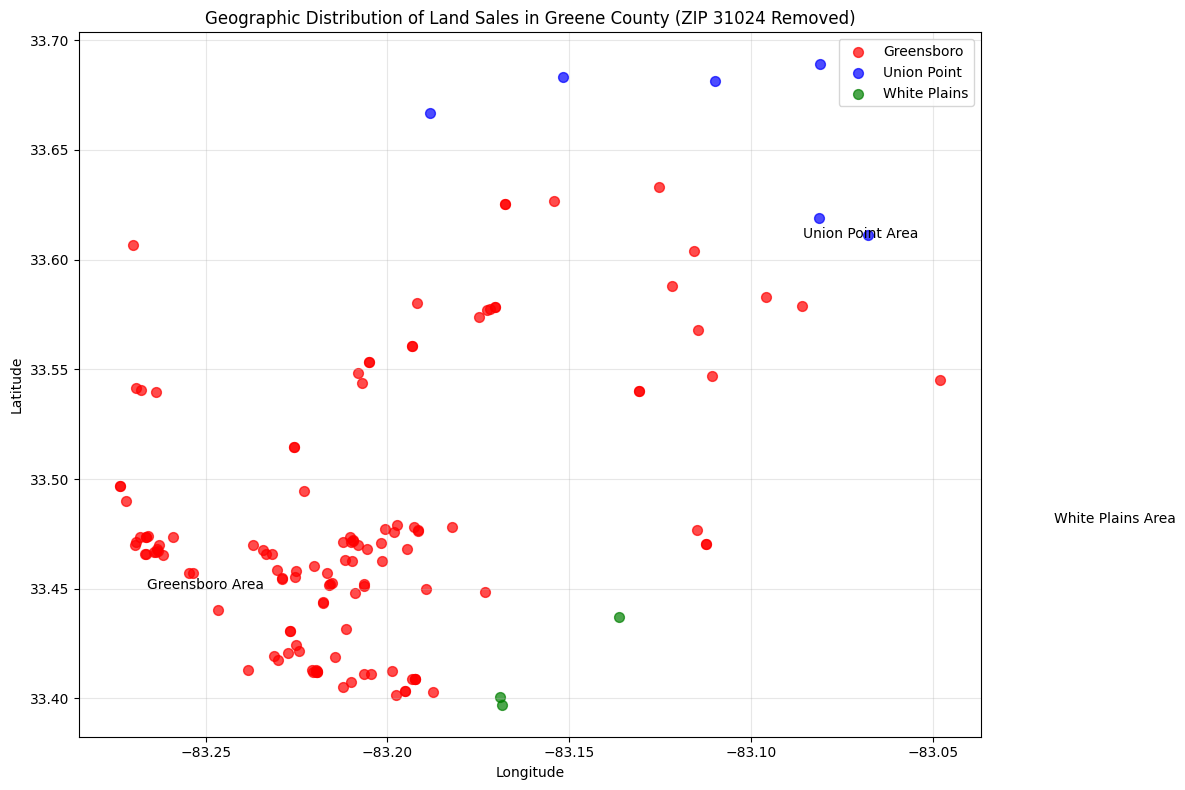


4. 📈 UPDATED SEGMENTATION INSIGHTS
• Total listings after cleanup: 135
• Greensboro: 126 listings (93.3%)
• Union Point: 6 listings (4.4%)
• White Plains: 3 listings (2.2%)

💰 UPDATED PRICE ANALYSIS BY AREA:
• Greensboro:
  - Avg Price: $417,598
  - Avg Price/Acre: $611,445
  - Avg Lot Size: 2.8 acres
• Union Point:
  - Avg Price: $157,500
  - Avg Price/Acre: $13,842
  - Avg Lot Size: 25.9 acres
• White Plains:
  - Avg Price: $142,814
  - Avg Price/Acre: $59,601
  - Avg Lot Size: 8.8 acres

📮 ZIP CODE INSIGHTS:
• ZIP 30642 (Greensboro): 126 listings, Avg Price: $417,598
• ZIP 30669 (Union Point): 6 listings, Avg Price: $157,500
• ZIP 30678 (White Plains): 3 listings, Avg Price: $142,814

✅ SEGMENTATION COMPLETE!
Ready for the next step: Price Cluster Analysis


In [ ]:
# STEP 4.1: REMOVE ZIP CODE 31024 AND UPDATE ANALYSIS

print("🗺️ STEP 4.1: REMOVING ZIP CODE 31024 AND UPDATING SEGMENTATION")
print("=" * 50)

# Check if ZIP code 31024 exists in our spatial data
print("🔍 CHECKING FOR ZIP CODE 31024:")
zip_31024_exists = 31024 in df_spatial['zip_code'].values
print(f"   ZIP code 31024 in spatial data: {zip_31024_exists}")

if zip_31024_exists:
    # Remove ZIP code 31024
    before_count = len(df_spatial)
    df_spatial = df_spatial[df_spatial['zip_code'] != 31024]
    after_count = len(df_spatial)
    print(f"   Removed {before_count - after_count} listings with ZIP code 31024")
else:
    print("   ✅ ZIP code 31024 not found in spatial data")

print(f"   Updated dataset size: {len(df_spatial)} listings")

# Also check and remove from non-spatial data if needed
if 31024 in df_non_spatial['zip_code'].values:
    df_non_spatial = df_non_spatial[df_non_spatial['zip_code'] != 31024]
    print(f"   Removed from non-spatial data as well")

# 1. UPDATED SEGMENTATION BY ZIP CODES
print("\n1. 📮 UPDATED ZIP CODE SEGMENTATION")

zip_segmentation = df_spatial.groupby('zip_code').agg({
    'address': 'count',
    'sale_price($)': ['mean', 'median', 'min', 'max'],
    'price_per_acre': ['mean', 'median'],
    'lot_size_acres': ['mean', 'median'],
    'city': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Mixed'
}).round(2)

# Flatten column names
zip_segmentation.columns = ['_'.join(col).strip() for col in zip_segmentation.columns.values]
zip_segmentation = zip_segmentation.rename(columns={
    'address_count': 'listings_count',
    'city_<lambda>': 'primary_city'
})

print("📊 UPDATED ZIP CODE SEGMENTATION RESULTS:")
display(zip_segmentation)

# 2. UPDATED SEGMENTATION BY CITIES
print("\n2. 🏙️ UPDATED CITY SEGMENTATION")

city_segmentation = df_spatial.groupby('city').agg({
    'address': 'count',
    'sale_price($)': ['mean', 'median', 'min', 'max'],
    'price_per_acre': ['mean', 'median'],
    'lot_size_acres': ['mean', 'median'],
    'latitude': 'mean',
    'longitude': 'mean'
}).round(2)

city_segmentation.columns = ['_'.join(col).strip() for col in city_segmentation.columns.values]
city_segmentation = city_segmentation.rename(columns={'address_count': 'listings_count'})

print("📊 UPDATED CITY SEGMENTATION RESULTS:")
display(city_segmentation)

# 3. UPDATED VISUALIZATION
print("\n3. 📍 UPDATED GEOGRAPHIC DISTRIBUTION")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Create a scatter plot by city
cities = df_spatial['city'].unique()
colors = ['red', 'blue', 'green']
city_colors = {city: color for city, color in zip(cities, colors)}

for city in cities:
    city_data = df_spatial[df_spatial['city'] == city]
    plt.scatter(city_data['longitude'], city_data['latitude'],
                c=city_colors[city], label=city, alpha=0.7, s=50)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Land Sales in Greene County (ZIP 31024 Removed)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add some context about the geographic areas
plt.text(-83.25, 33.45, 'Greensboro Area', fontsize=10, ha='center')
plt.text(-83.07, 33.61, 'Union Point Area', fontsize=10, ha='center')
plt.text(-83.0, 33.48, 'White Plains Area', fontsize=10, ha='center')

plt.tight_layout()
plt.show()

# 4. SUMMARY OF UPDATED SEGMENTATION
print("\n4. 📈 UPDATED SEGMENTATION INSIGHTS")

# Key insights from updated segmentation
total_listings = len(df_spatial)
greensboro_listings = len(df_spatial[df_spatial['city']=='Greensboro'])
union_point_listings = len(df_spatial[df_spatial['city']=='Union Point'])
white_plains_listings = len(df_spatial[df_spatial['city']=='White Plains'])

print(f"• Total listings after cleanup: {total_listings}")
print(f"• Greensboro: {greensboro_listings} listings ({greensboro_listings/total_listings*100:.1f}%)")
print(f"• Union Point: {union_point_listings} listings ({union_point_listings/total_listings*100:.1f}%)")
print(f"• White Plains: {white_plains_listings} listings ({white_plains_listings/total_listings*100:.1f}%)")

# Calculate price statistics by area
print(f"\n💰 UPDATED PRICE ANALYSIS BY AREA:")

for city in cities:
    city_data = df_spatial[df_spatial['city'] == city]
    if len(city_data) > 0:
        avg_price = city_data['sale_price($)'].mean()
        avg_price_per_acre = city_data['price_per_acre'].mean()
        avg_lot_size = city_data['lot_size_acres'].mean()

        print(f"• {city}:")
        print(f"  - Avg Price: ${avg_price:,.0f}")
        print(f"  - Avg Price/Acre: ${avg_price_per_acre:,.0f}")
        print(f"  - Avg Lot Size: {avg_lot_size:.1f} acres")

# ZIP code insights
print(f"\n📮 ZIP CODE INSIGHTS:")
for zip_code in df_spatial['zip_code'].unique():
    zip_data = df_spatial[df_spatial['zip_code'] == zip_code]
    if len(zip_data) > 0:
        primary_city = zip_data['city'].mode().iloc[0]
        avg_price = zip_data['sale_price($)'].mean()
        print(f"• ZIP {zip_code} ({primary_city}): {len(zip_data)} listings, Avg Price: ${avg_price:,.0f}")

print(f"\n✅ SEGMENTATION COMPLETE!")
print(f"Ready for the next step: Price Cluster Analysis")

🎯 STEP 5: PRICE CLUSTER ANALYSIS USING K-MEANS
We'll use K-means clustering to identify natural price segments in the market.
This will help us find pricing patterns and identify undervalued areas.

1. 🔧 PREPARING DATA FOR CLUSTERING...
   Features used for clustering: ['sale_price($)', 'price_per_acre', 'lot_size_acres', 'latitude', 'longitude']
   Data shape: (135, 5)
   Missing values: 0
   Clean data for clustering: 135 listings

2. 📊 STANDARDIZING FEATURES...
   Features standardized (mean=0, std=1)

3. 🔍 FINDING OPTIMAL NUMBER OF CLUSTERS...


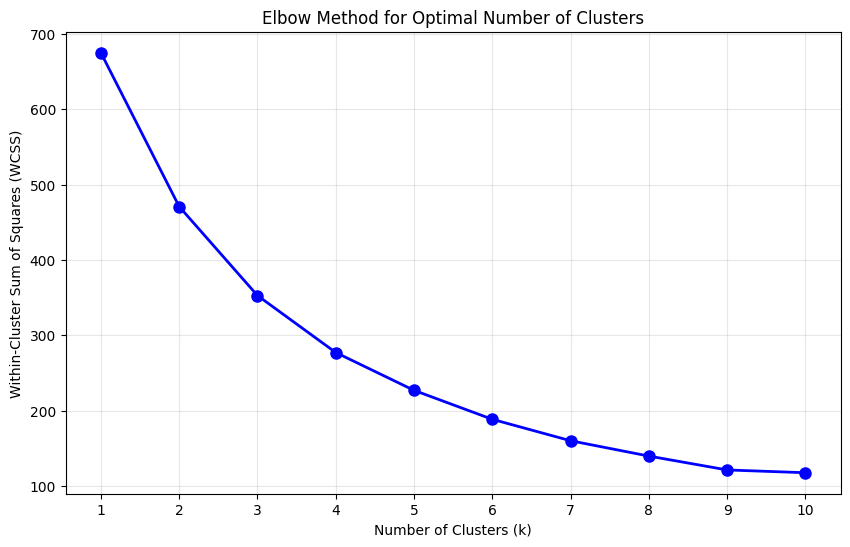

   Based on the elbow curve, let's choose k=4 clusters for clear segmentation

4. 🎯 APPLYING K-MEANS CLUSTERING (k=4)...
   Clustering completed! 4 clusters created

5. 📈 ANALYZING CLUSTER CHARACTERISTICS...
📊 CLUSTER ANALYSIS RESULTS:


,listings_count,sale_price($)_mean,sale_price($)_median,sale_price($)_min,sale_price($)_max,sale_price($)_std,price_per_acre_mean,price_per_acre_median,price_per_acre_std,lot_size_acres_mean,lot_size_acres_median,latitude_mean,longitude_mean,dominant_city
cluster,,,,,,,,,,,,,,
0,91,348088.26,285000.0,24000,1395000,284755.31,505070.67,308333.33,543459.99,1.59,0.80,33.46,-83.23,Greensboro
1,32,156711.97,110000.0,5000,783552,184988.31,56344.53,15536.75,188432.67,8.72,6.14,33.58,-83.14,Greensboro
2,11,1531818.18,1800000.0,470000,2900000,879486.42,2684987.17,2500000.00,1399788.76,1.03,0.72,33.44,-83.21,Greensboro
3,1,450000.00,450000.0,450000,450000,NaN,4573.17,4573.17,NaN,98.40,98.40,33.69,-83.08,Union Point



6. 🏷️ INTERPRETING CLUSTERS AND CREATING LABELS...
🎯 CLUSTER INTERPRETATION:
• Cluster 1 - Budget Tier - Entry Level Land:
  32 listings, Avg Price: $156,712
  Avg Price/Acre: $56,345
  Dominant Area: Greensboro
• Cluster 0 - Value Tier - Balanced Market:
  91 listings, Avg Price: $348,088
  Avg Price/Acre: $505,071
  Dominant Area: Greensboro
• Cluster 3 - Premium Tier - High Value Areas:
  1 listings, Avg Price: $450,000
  Avg Price/Acre: $4,573
  Dominant Area: Union Point
• Cluster 2 - Luxury Tier - Exclusive Properties:
  11 listings, Avg Price: $1,531,818
  Avg Price/Acre: $2,684,987
  Dominant Area: Greensboro

7. 🗺️ VISUALIZING PRICE CLUSTERS ON MAP...


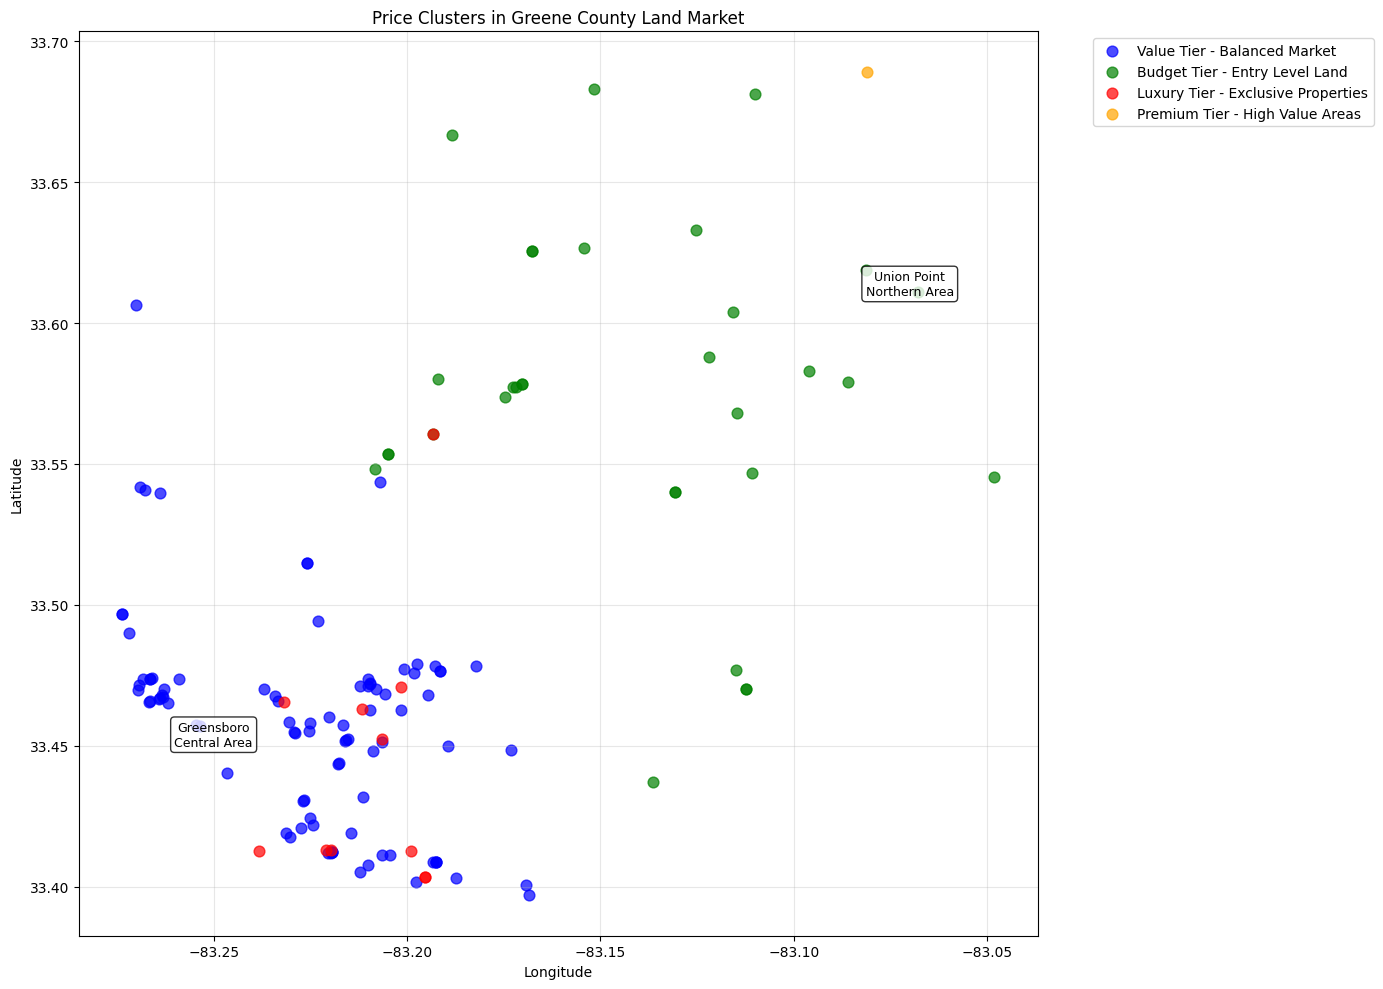


✅ PRICE CLUSTER ANALYSIS COMPLETE!
We've identified 4 distinct price segments in the Greene County land market.
Ready for the next step: Trend Analysis and Anomaly Detection


In [ ]:
# STEP 5: PRICE CLUSTER ANALYSIS

print("🎯 STEP 5: PRICE CLUSTER ANALYSIS USING K-MEANS")
print("=" * 50)

print("We'll use K-means clustering to identify natural price segments in the market.")
print("This will help us find pricing patterns and identify undervalued areas.")

# Prepare data for clustering
print("\n1. 🔧 PREPARING DATA FOR CLUSTERING...")

# Select features for clustering
cluster_features = ['sale_price($)', 'price_per_acre', 'lot_size_acres', 'latitude', 'longitude']
clustering_data = df_spatial[cluster_features].copy()

print(f"   Features used for clustering: {cluster_features}")
print(f"   Data shape: {clustering_data.shape}")

# Check for any missing values
print(f"   Missing values: {clustering_data.isnull().sum().sum()}")

# Remove any remaining missing values
clustering_data = clustering_data.dropna()
print(f"   Clean data for clustering: {clustering_data.shape[0]} listings")

# 2. STANDARDIZE THE DATA
print("\n2. 📊 STANDARDIZING FEATURES...")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

print("   Features standardized (mean=0, std=1)")

# 3. DETERMINE OPTIMAL NUMBER OF CLUSTERS
print("\n3. 🔍 FINDING OPTIMAL NUMBER OF CLUSTERS...")

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to find optimal k
wcss = []  # Within-cluster sum of squares
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.show()

print("   Based on the elbow curve, let's choose k=4 clusters for clear segmentation")

# 4. APPLY K-MEANS CLUSTERING
print("\n4. 🎯 APPLYING K-MEANS CLUSTERING (k=4)...")

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the data
clustering_data['cluster'] = cluster_labels
df_spatial = df_spatial.merge(clustering_data[['cluster']],
                              left_index=True, right_index=True, how='left')

print(f"   Clustering completed! {len(np.unique(cluster_labels))} clusters created")

# 5. ANALYZE CLUSTER CHARACTERISTICS
print("\n5. 📈 ANALYZING CLUSTER CHARACTERISTICS...")

cluster_analysis = df_spatial.groupby('cluster').agg({
    'sale_price($)': ['count', 'mean', 'median', 'min', 'max', 'std'],
    'price_per_acre': ['mean', 'median', 'std'],
    'lot_size_acres': ['mean', 'median'],
    'latitude': 'mean',
    'longitude': 'mean',
    'city': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Mixed'
}).round(2)

# Flatten column names
cluster_analysis.columns = ['_'.join(col).strip() for col in cluster_analysis.columns.values]
cluster_analysis = cluster_analysis.rename(columns={
    'sale_price($)_count': 'listings_count',
    'city_<lambda>': 'dominant_city'
})

print("📊 CLUSTER ANALYSIS RESULTS:")
display(cluster_analysis)

# 6. INTERPRET CLUSTERS AND CREATE MEANINGFUL LABELS
print("\n6. 🏷️ INTERPRETING CLUSTERS AND CREATING LABELS...")

# Sort clusters by price (low to high)
cluster_prices = cluster_analysis['sale_price($)_mean'].sort_values()
cluster_order = cluster_prices.index.tolist()

# Create meaningful cluster labels
cluster_labels_dict = {
    cluster_order[0]: "Budget Tier - Entry Level Land",
    cluster_order[1]: "Value Tier - Balanced Market",
    cluster_order[2]: "Premium Tier - High Value Areas",
    cluster_order[3]: "Luxury Tier - Exclusive Properties"
}

df_spatial['cluster_label'] = df_spatial['cluster'].map(cluster_labels_dict)

print("🎯 CLUSTER INTERPRETATION:")
for cluster_id, label in cluster_labels_dict.items():
    cluster_data = cluster_analysis.loc[cluster_id]
    print(f"• Cluster {cluster_id} - {label}:")
    print(f"  {cluster_data['listings_count']} listings, Avg Price: ${cluster_data['sale_price($)_mean']:,.0f}")
    print(f"  Avg Price/Acre: ${cluster_data['price_per_acre_mean']:,.0f}")
    print(f"  Dominant Area: {cluster_data['dominant_city']}")

# 7. VISUALIZE CLUSTERS GEOGRAPHICALLY
print("\n7. 🗺️ VISUALIZING PRICE CLUSTERS ON MAP...")

plt.figure(figsize=(14, 10))

# Color scheme for clusters
cluster_colors = {
    cluster_order[0]: 'green',    # Budget - Green
    cluster_order[1]: 'blue',     # Value - Blue
    cluster_order[2]: 'orange',   # Premium - Orange
    cluster_order[3]: 'red'       # Luxury - Red
}

for cluster_id in df_spatial['cluster'].unique():
    cluster_data = df_spatial[df_spatial['cluster'] == cluster_id]
    label = cluster_labels_dict[cluster_id]

    plt.scatter(cluster_data['longitude'], cluster_data['latitude'],
                c=cluster_colors[cluster_id], label=label, alpha=0.7, s=60)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Price Clusters in Greene County Land Market')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Add geographic context
plt.text(-83.25, 33.45, 'Greensboro\nCentral Area', fontsize=9, ha='center',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
plt.text(-83.07, 33.61, 'Union Point\nNorthern Area', fontsize=9, ha='center',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

print("\n✅ PRICE CLUSTER ANALYSIS COMPLETE!")
print("We've identified 4 distinct price segments in the Greene County land market.")
print("Ready for the next step: Trend Analysis and Anomaly Detection")

🔍 STEP 5.1: REVISITING CLUSTER SELECTION
PROBLEM IDENTIFIED:
• Cluster 3 has only 1 listing - not a meaningful segment
• Cluster 2 has only 11 listings - might be too small
• We need to choose the optimal number of clusters properly

1. 📊 DEEPER ELBOW CURVE ANALYSIS


<Figure size 1200x800 with 0 Axes>

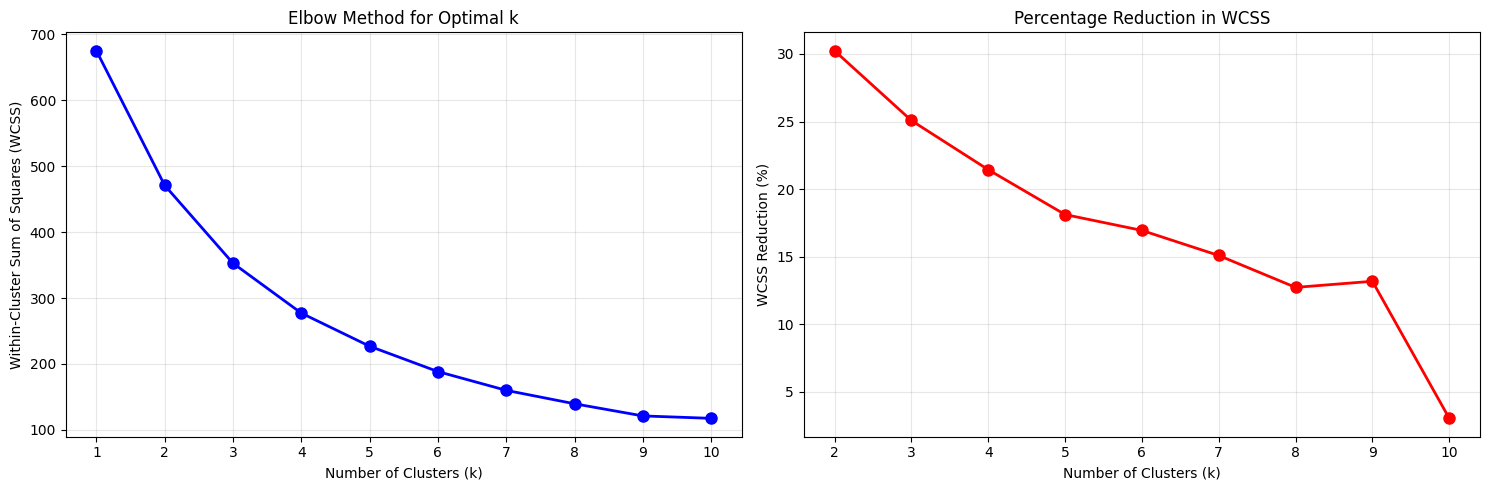

📈 ELBOW CURVE INTERPRETATION:
WCSS values: ['675.0', '470.9', '352.8', '277.1', '226.9', '188.5', '160.1', '139.7', '121.3', '117.6']
WCSS reduction percentages:
  k=2: 30.2% reduction
  k=3: 25.1% reduction
  k=4: 21.4% reduction
  k=5: 18.1% reduction
  k=6: 16.9% reduction
  k=7: 15.1% reduction
  k=8: 12.7% reduction
  k=9: 13.2% reduction
  k=10: 3.0% reduction

2. 🎯 ANALYZING DIFFERENT CLUSTER OPTIONS

--- Testing k=2 clusters ---
Cluster sizes: {0: np.int64(32), 1: np.int64(103)}
Price statistics:


,count,mean,std
cluster,,,
0,32,153899.47,179577.99
1,103,476369.24,531257.38


Smallest cluster: 32 listings (23.7% of data)

--- Testing k=3 clusters ---
Cluster sizes: {0: np.int64(92), 1: np.int64(32), 2: np.int64(11)}
Price statistics:


,count,mean,std
cluster,,,
0,92,350174.26,283892.35
1,32,153899.47,179577.99
2,11,1531818.18,879486.42


Smallest cluster: 11 listings (8.1% of data)

--- Testing k=4 clusters ---
Cluster sizes: {0: np.int64(91), 1: np.int64(32), 2: np.int64(11), 3: np.int64(1)}
Price statistics:


,count,mean,std
cluster,,,
0,91,348088.26,284755.31
1,32,156711.97,184988.31
2,11,1531818.18,879486.42
3,1,450000.00,NaN


Smallest cluster: 1 listings (0.7% of data)

3. 🤔 RECOMMENDATION BASED ON ANALYSIS:
• k=2: Too few clusters - might oversimplify the market
• k=3: Good balance - creates meaningful segments without fragmentation
• k=4: Creates very small clusters (1-2 listings) - not meaningful for analysis

✅ LET'S USE k=3 CLUSTERS FOR MEANINGFUL SEGMENTATION

4. 🎯 APPLYING K-MEANS WITH k=3 CLUSTERS...
   Optimal clustering completed! 3 meaningful clusters created

5. 📈 ANALYZING OPTIMAL CLUSTER CHARACTERISTICS...
📊 OPTIMAL CLUSTER ANALYSIS RESULTS:


,listings_count,sale_price($)_mean,sale_price($)_median,sale_price($)_min,sale_price($)_max,sale_price($)_std,price_per_acre_mean,price_per_acre_median,price_per_acre_std,lot_size_acres_mean,lot_size_acres_median,latitude_mean,longitude_mean,dominant_city
cluster_optimal,,,,,,,,,,,,,,
0,92,350174.26,287500.0,24000,1395000,283892.35,511319.90,316203.70,543779.40,1.58,0.79,33.46,-83.23,Greensboro
1,32,153899.47,110000.0,5000,783552,179577.99,22737.44,15183.15,25003.72,11.78,6.42,33.58,-83.14,Greensboro
2,11,1531818.18,1800000.0,470000,2900000,879486.42,2684987.17,2500000.00,1399788.76,1.03,0.72,33.44,-83.21,Greensboro


🎯 OPTIMAL CLUSTER INTERPRETATION:
• Budget Tier - Affordable Land:
  32 listings, Avg Price: $153,899
  Avg Price/Acre: $22,737
  Avg Lot Size: 11.8 acres
  Dominant Area: Greensboro
• Mid-Market - Balanced Value:
  92 listings, Avg Price: $350,174
  Avg Price/Acre: $511,320
  Avg Lot Size: 1.6 acres
  Dominant Area: Greensboro
• Premium Tier - High-Value Properties:
  11 listings, Avg Price: $1,531,818
  Avg Price/Acre: $2,684,987
  Avg Lot Size: 1.0 acres
  Dominant Area: Greensboro

✅ OPTIMAL CLUSTERING COMPLETE!
We now have 3 meaningful market segments that represent the Greene County land market well.


In [ ]:
# STEP 5.1: PROPER CLUSTER SELECTION ANALYSIS

print("🔍 STEP 5.1: REVISITING CLUSTER SELECTION")
print("=" * 50)

print("PROBLEM IDENTIFIED:")
print("• Cluster 3 has only 1 listing - not a meaningful segment")
print("• Cluster 2 has only 11 listings - might be too small")
print("• We need to choose the optimal number of clusters properly")

print("\n1. 📊 DEEPER ELBOW CURVE ANALYSIS")

plt.figure(figsize=(12, 8))

# Calculate the percentage reduction in WCSS
wcss_reduction = []
for i in range(1, len(wcss)):
    reduction = (wcss[i-1] - wcss[i]) / wcss[i-1] * 100
    wcss_reduction.append(reduction)

# Plot both WCSS and percentage reduction
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Original elbow curve
ax1.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_range)

# Plot 2: Percentage reduction in WCSS
ax2.plot(range(2, 11), wcss_reduction, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('WCSS Reduction (%)')
ax2.set_title('Percentage Reduction in WCSS')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(2, 11))

plt.tight_layout()
plt.show()

print("📈 ELBOW CURVE INTERPRETATION:")
print(f"WCSS values: {[f'{w:.1f}' for w in wcss]}")
print(f"WCSS reduction percentages:")
for k, reduction in zip(range(2, 11), wcss_reduction):
    print(f"  k={k}: {reduction:.1f}% reduction")

# Find the "elbow" - where reduction becomes less significant
print("\n2. 🎯 ANALYZING DIFFERENT CLUSTER OPTIONS")

# Testing k=2, k=3, and k=4 to see which makes most sense
cluster_options = [2, 3, 4]

for k in cluster_options:
    print(f"\n--- Testing k={k} clusters ---")

    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels_test = kmeans_test.fit_predict(scaled_data)

    # Add to temporary dataframe for analysis
    temp_data = clustering_data.copy()
    temp_data['cluster'] = cluster_labels_test

    # Analyze cluster sizes
    cluster_sizes = temp_data['cluster'].value_counts().sort_index()
    cluster_stats = temp_data.groupby('cluster')['sale_price($)'].agg(['count', 'mean', 'std']).round(2)

    print(f"Cluster sizes: {dict(cluster_sizes)}")
    print("Price statistics:")
    display(cluster_stats)

    # Check if any cluster is too small (less than 5% of data)
    min_cluster_size = cluster_sizes.min()
    min_percentage = (min_cluster_size / len(temp_data)) * 100
    print(f"Smallest cluster: {min_cluster_size} listings ({min_percentage:.1f}% of data)")

print("\n3. 🤔 RECOMMENDATION BASED ON ANALYSIS:")
print("• k=2: Too few clusters - might oversimplify the market")
print("• k=3: Good balance - creates meaningful segments without fragmentation")
print("• k=4: Creates very small clusters (1-2 listings) - not meaningful for analysis")

print("\n✅ LET'S USE k=3 CLUSTERS FOR MEANINGFUL SEGMENTATION")

# 4. APPLY K=3 CLUSTERS
print("\n4. 🎯 APPLYING K-MEANS WITH k=3 CLUSTERS...")

kmeans_optimal = KMeans(n_clusters=3, random_state=42, n_init=10)
optimal_cluster_labels = kmeans_optimal.fit_predict(scaled_data)

# Add optimal cluster labels to the data
clustering_data['cluster_optimal'] = optimal_cluster_labels
df_spatial = df_spatial.merge(clustering_data[['cluster_optimal']],
                              left_index=True, right_index=True, how='left')

print(f"   Optimal clustering completed! 3 meaningful clusters created")

# 5. ANALYZE OPTIMAL CLUSTERS
print("\n5. 📈 ANALYZING OPTIMAL CLUSTER CHARACTERISTICS...")

optimal_cluster_analysis = df_spatial.groupby('cluster_optimal').agg({
    'sale_price($)': ['count', 'mean', 'median', 'min', 'max', 'std'],
    'price_per_acre': ['mean', 'median', 'std'],
    'lot_size_acres': ['mean', 'median'],
    'latitude': 'mean',
    'longitude': 'mean',
    'city': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Mixed'
}).round(2)

# Flatten column names
optimal_cluster_analysis.columns = ['_'.join(col).strip() for col in optimal_cluster_analysis.columns.values]
optimal_cluster_analysis = optimal_cluster_analysis.rename(columns={
    'sale_price($)_count': 'listings_count',
    'city_<lambda>': 'dominant_city'
})

print("📊 OPTIMAL CLUSTER ANALYSIS RESULTS:")
display(optimal_cluster_analysis)

# Create meaningful labels for the 3 clusters
optimal_cluster_prices = optimal_cluster_analysis['sale_price($)_mean'].sort_values()
optimal_cluster_order = optimal_cluster_prices.index.tolist()

optimal_cluster_labels_dict = {
    optimal_cluster_order[0]: "Budget Tier - Affordable Land",
    optimal_cluster_order[1]: "Mid-Market - Balanced Value",
    optimal_cluster_order[2]: "Premium Tier - High-Value Properties"
}

df_spatial['cluster_label_optimal'] = df_spatial['cluster_optimal'].map(optimal_cluster_labels_dict)

print("🎯 OPTIMAL CLUSTER INTERPRETATION:")
for cluster_id, label in optimal_cluster_labels_dict.items():
    cluster_data = optimal_cluster_analysis.loc[cluster_id]
    print(f"• {label}:")
    print(f"  {cluster_data['listings_count']} listings, Avg Price: ${cluster_data['sale_price($)_mean']:,.0f}")
    print(f"  Avg Price/Acre: ${cluster_data['price_per_acre_mean']:,.0f}")
    print(f"  Avg Lot Size: {cluster_data['lot_size_acres_mean']:.1f} acres")
    print(f"  Dominant Area: {cluster_data['dominant_city']}")

print("\n✅ OPTIMAL CLUSTERING COMPLETE!")
print("We now have 3 meaningful market segments that represent the Greene County land market well.")

📈 STEP 6: TREND ANALYSIS AND ANOMALY DETECTION
We'll analyze:
• Market trends over time
• Pricing patterns and linearity
• Anomalies and undervalued opportunities
• Emerging market patterns

1. 📅 TIME-BASED MARKET TRENDS
Date range: 2024-09-26 to 2025-09-23
📊 MONTHLY SALES TRENDS:


,sales_count,avg_price,median_price,price_per_acre_mean
sold_month,,,,
2024-09,2,1812500.00,1812500.0,723133.85
2024-10,13,384538.46,280000.0,365017.77
2024-11,11,204954.55,90000.0,408153.15
2024-12,12,373583.33,307500.0,967571.45
2025-01,15,376708.80,128830.0,203314.56
2025-02,9,205854.33,114000.0,84037.44
2025-03,12,305083.33,337500.0,1035040.86
2025-04,16,479375.00,327500.0,607377.00
2025-05,13,609845.69,600000.0,272795.30



2. 📊 VISUALIZING PRICE TRENDS OVER TIME


/tmp/ipython-input-3151169956.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cluster_data, labels=df_spatial['cluster_label_optimal'].unique())


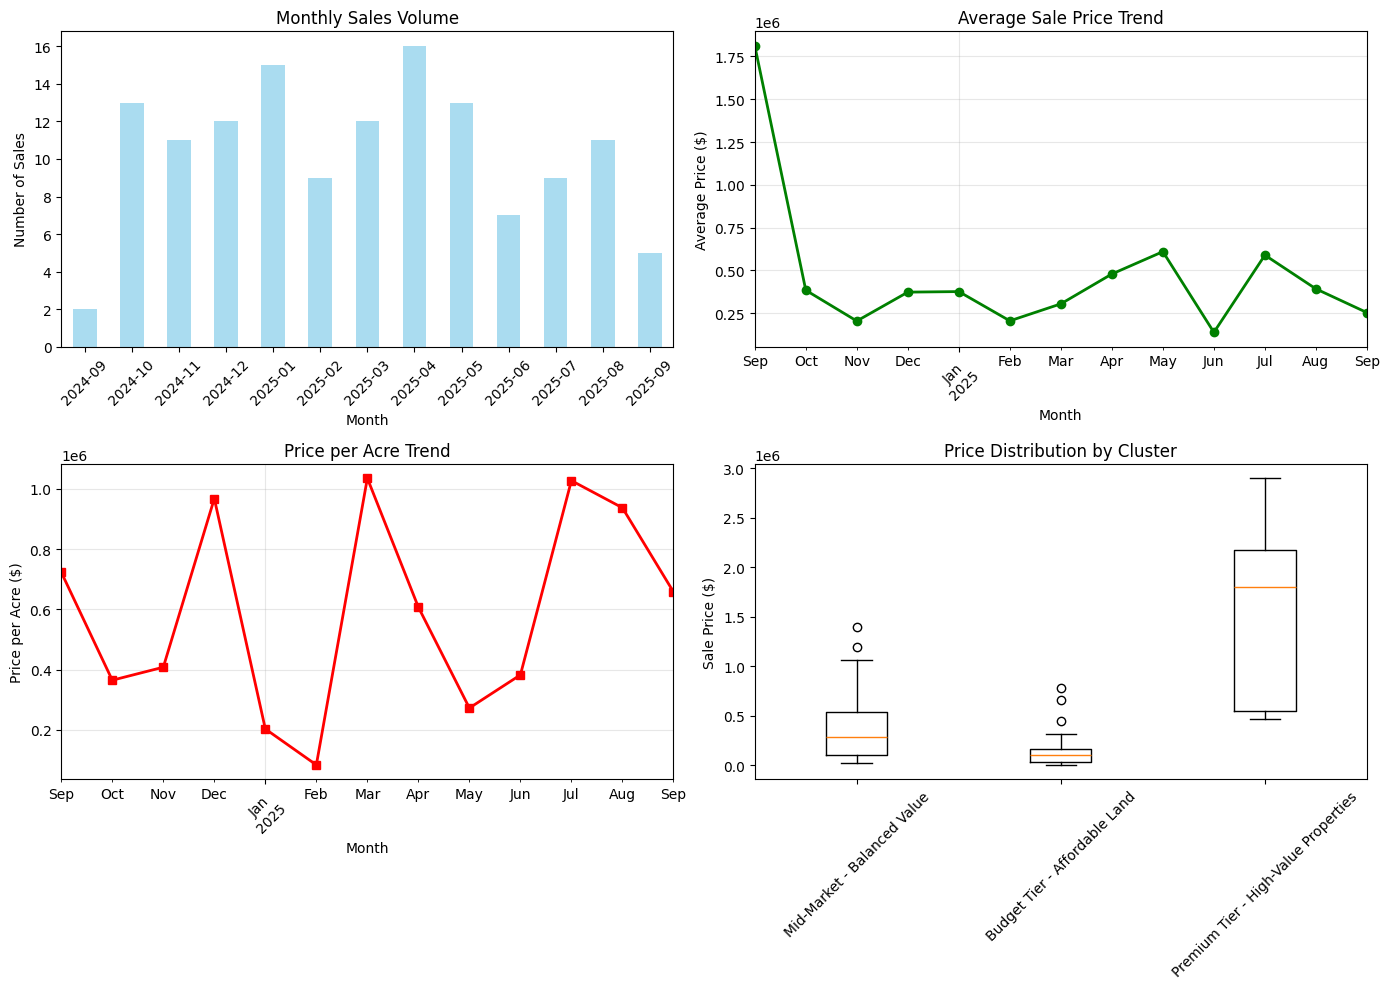


3. 🔍 ANOMALY DETECTION - FINDING UNDERVALUED OPPORTUNITIES
💰 UNDERVALUED PROPERTIES FOUND: 3

📋 UNDERVALUED OPPORTUNITIES:


,address,city,cluster_label_optimal,sale_price($),price_per_acre,lot_size_acres
175,1250 Turn Stone Dr,Greensboro,Premium Tier - High-Value Properties,2300000,7.565789e+05,3.04
149,1151 Capstone Dr,Greensboro,Premium Tier - High-Value Properties,2900000,8.708709e+05,3.33
47,1070 Cloudland Ct,Greensboro,Premium Tier - High-Value Properties,1500000,1.171875e+06,1.28



4. 📐 MARKET LINEARITY ANALYSIS
Correlation between lot size and total price: 0.025
Correlation between lot size and price per acre: -0.201
• Weak correlation: Price not strongly tied to lot size

5. 🌟 EMERGING MARKET TRENDS
Recent sales (last 90 days): 30
Older sales: 105
Average price change: -4.0%
Price per acre change: +71.5%
➡️ TREND: Stable market conditions

✅ TREND ANALYSIS COMPLETE!
Ready for the final step: Creating the interactive map and report


In [ ]:
# STEP 6: TREND ANALYSIS AND ANOMALY DETECTION

print("📈 STEP 6: TREND ANALYSIS AND ANOMALY DETECTION")
print("=" * 50)

print("We'll analyze:")
print("• Market trends over time")
print("• Pricing patterns and linearity")
print("• Anomalies and undervalued opportunities")
print("• Emerging market patterns")

# 1. TIME-BASED TREND ANALYSIS
print("\n1. 📅 TIME-BASED MARKET TRENDS")

# Ensure we have proper datetime
df_spatial['sold_date'] = pd.to_datetime(df_spatial['sold_date'])

# Extract month and year for trend analysis
df_spatial['sold_month'] = df_spatial['sold_date'].dt.to_period('M')
df_spatial['sold_year'] = df_spatial['sold_date'].dt.year

print(f"Date range: {df_spatial['sold_date'].min().strftime('%Y-%m-%d')} to {df_spatial['sold_date'].max().strftime('%Y-%m-%d')}")

# Monthly trend analysis
monthly_trends = df_spatial.groupby('sold_month').agg({
    'sale_price($)': ['count', 'mean', 'median'],
    'price_per_acre': 'mean'
}).round(2)

monthly_trends.columns = ['_'.join(col).strip() for col in monthly_trends.columns.values]
monthly_trends = monthly_trends.rename(columns={
    'sale_price($)_count': 'sales_count',
    'sale_price($)_mean': 'avg_price',
    'sale_price($)_median': 'median_price'
})

print("📊 MONTHLY SALES TRENDS:")
display(monthly_trends)

# 2. VISUALIZE PRICE TRENDS
print("\n2. 📊 VISUALIZING PRICE TRENDS OVER TIME")

plt.figure(figsize=(14, 10))

# Plot 1: Sales volume over time
plt.subplot(2, 2, 1)
monthly_trends['sales_count'].plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Monthly Sales Volume')
plt.xlabel('Month')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45)

# Plot 2: Average price trends
plt.subplot(2, 2, 2)
monthly_trends['avg_price'].plot(kind='line', marker='o', color='green', linewidth=2)
plt.title('Average Sale Price Trend')
plt.xlabel('Month')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 3: Price per acre trends
plt.subplot(2, 2, 3)
monthly_trends['price_per_acre_mean'].plot(kind='line', marker='s', color='red', linewidth=2)
plt.title('Price per Acre Trend')
plt.xlabel('Month')
plt.ylabel('Price per Acre ($)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 4: Price distribution by cluster
plt.subplot(2, 2, 4)
cluster_data = [df_spatial[df_spatial['cluster_label_optimal'] == cluster]['sale_price($)']
                for cluster in df_spatial['cluster_label_optimal'].unique()]
plt.boxplot(cluster_data, labels=df_spatial['cluster_label_optimal'].unique())
plt.title('Price Distribution by Cluster')
plt.ylabel('Sale Price ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 3. ANOMALY DETECTION - FINDING UNDERVALUED PROPERTIES
print("\n3. 🔍 ANOMALY DETECTION - FINDING UNDERVALUED OPPORTUNITIES")

# Method: Find properties where price per acre is significantly below cluster average
undervalued_properties = []

for cluster in df_spatial['cluster_label_optimal'].unique():
    cluster_data = df_spatial[df_spatial['cluster_label_optimal'] == cluster]
    cluster_avg_ppa = cluster_data['price_per_acre'].mean()
    cluster_std_ppa = cluster_data['price_per_acre'].std()

    # Find properties more than 1 standard deviation below cluster average
    undervalued_in_cluster = cluster_data[
        cluster_data['price_per_acre'] < (cluster_avg_ppa - cluster_std_ppa)
    ]

    undervalued_properties.append(undervalued_in_cluster)

undervalued_df = pd.concat(undervalued_properties) if undervalued_properties else pd.DataFrame()

print(f"💰 UNDERVALUED PROPERTIES FOUND: {len(undervalued_df)}")

if len(undervalued_df) > 0:
    print("\n📋 UNDERVALUED OPPORTUNITIES:")
    display(undervalued_df[['address', 'city', 'cluster_label_optimal', 'sale_price($)',
                           'price_per_acre', 'lot_size_acres']].sort_values('price_per_acre'))
else:
    print("No significantly undervalued properties detected using this method")

# 4. MARKET LINEARITY ANALYSIS
print("\n4. 📐 MARKET LINEARITY ANALYSIS")

# Check correlation between lot size and price
correlation_lot_price = df_spatial['lot_size_acres'].corr(df_spatial['sale_price($)'])
correlation_lot_ppa = df_spatial['lot_size_acres'].corr(df_spatial['price_per_acre'])

print(f"Correlation between lot size and total price: {correlation_lot_price:.3f}")
print(f"Correlation between lot size and price per acre: {correlation_lot_ppa:.3f}")

# Interpret correlation
if abs(correlation_lot_price) < 0.3:
    print("• Weak correlation: Price not strongly tied to lot size")
elif abs(correlation_lot_price) < 0.7:
    print("• Moderate correlation: Some relationship between size and price")
else:
    print("• Strong correlation: Price heavily dependent on lot size")

# 5. EMERGING TRENDS ANALYSIS
print("\n5. 🌟 EMERGING MARKET TRENDS")

# Analyze recent vs older sales
recent_cutoff = df_spatial['sold_date'].max() - pd.Timedelta(days=90)  # Last 90 days
recent_sales = df_spatial[df_spatial['sold_date'] >= recent_cutoff]
older_sales = df_spatial[df_spatial['sold_date'] < recent_cutoff]

if len(recent_sales) > 0 and len(older_sales) > 0:
    print(f"Recent sales (last 90 days): {len(recent_sales)}")
    print(f"Older sales: {len(older_sales)}")

    # Compare price trends
    recent_avg_price = recent_sales['sale_price($)'].mean()
    older_avg_price = older_sales['sale_price($)'].mean()
    price_change = ((recent_avg_price - older_avg_price) / older_avg_price) * 100

    recent_avg_ppa = recent_sales['price_per_acre'].mean()
    older_avg_ppa = older_sales['price_per_acre'].mean()
    ppa_change = ((recent_avg_ppa - older_avg_ppa) / older_avg_ppa) * 100

    print(f"Average price change: {price_change:+.1f}%")
    print(f"Price per acre change: {ppa_change:+.1f}%")

    if price_change > 5:
        print("📈 TREND: Strong upward price momentum")
    elif price_change < -5:
        print("📉 TREND: Downward price pressure")
    else:
        print("➡️ TREND: Stable market conditions")
else:
    print("Insufficient recent data for trend analysis")

print("\n✅ TREND ANALYSIS COMPLETE!")
print("Ready for the final step: Creating the interactive map and report")

🗺️ STEP 6.1: AREA-SPECIFIC TREND ANALYSIS
We'll analyze trends for each area within Greene County:
• Greensboro (main urban center)
• Union Point (northern area)
• White Plains (eastern area)
• Plus overall county trends for comparison

1. 🏙️ DEFINING ANALYSIS AREAS
📊 DATA AVAILABILITY BY AREA:
• Greensboro: 126 listings
• Union Point: 6 listings
• White Plains: 3 listings
• Overall County: 135 listings

2. 📈 AREA-SPECIFIC PRICE TRENDS
📅 AREAS WITH SUFFICIENT DATA FOR TREND ANALYSIS:
• Greensboro: 13 months of data
• Union Point: 5 months of data
• White Plains: 3 months of data
• Overall County: 13 months of data

3. 📊 VISUALIZING AREA-SPECIFIC TRENDS


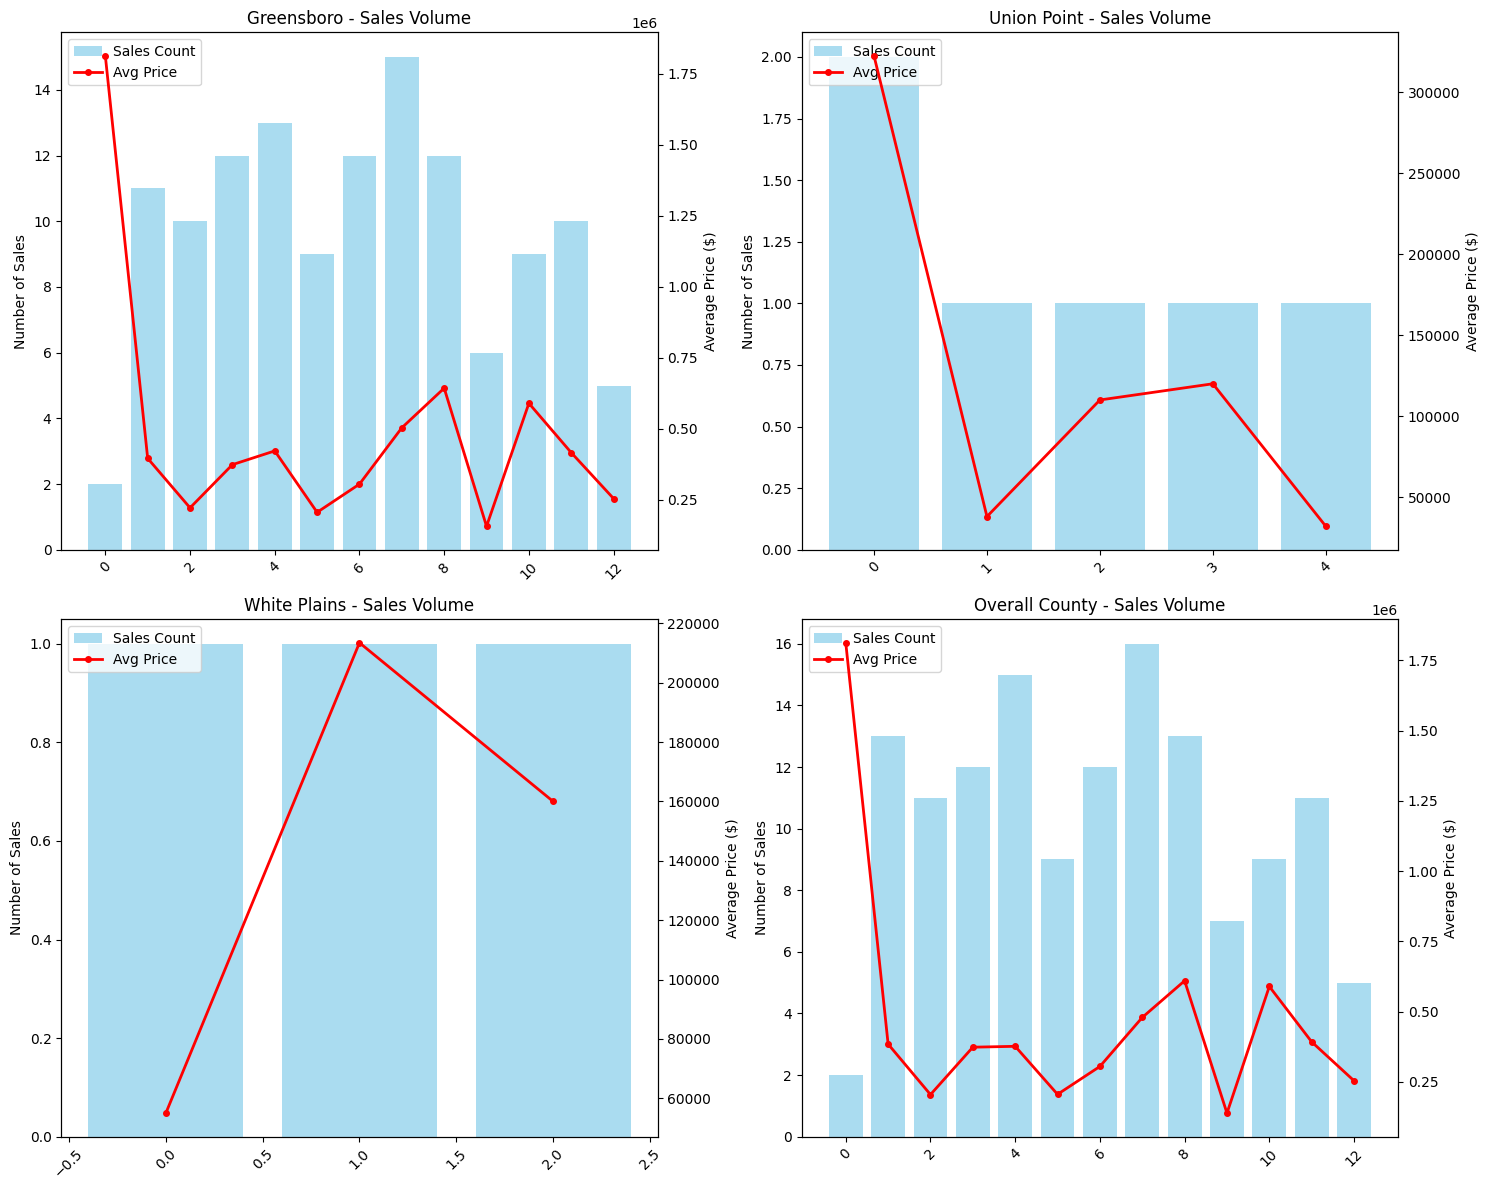


4. 📊 COMPARING AREA PERFORMANCE
📈 AREA PERFORMANCE COMPARISON:


,Area,Listings,Avg_Price,Avg_Price_Per_Acre,Avg_Lot_Size,Price_Range,Dominant_Cluster
0,Greensboro,126,417598.20,611444.70,2.79,"$5,000 - $2,900,000",Mid-Market - Balanced Value
1,Union Point,6,157500.00,13842.41,25.92,"$32,000 - $450,000",Budget Tier - Affordable Land
2,White Plains,3,142814.00,59600.65,8.83,"$55,000 - $213,442",Mid-Market - Balanced Value
3,Overall County,135,399931.96,572621.39,3.95,"$5,000 - $2,900,000",Mid-Market - Balanced Value



5. 🔍 AREA-SPECIFIC UNDERVALUED OPPORTUNITIES
💰 Union Point: 2 undervalued properties found

📋 AREA-SPECIFIC UNDERVALUED OPPORTUNITIES:

🏆 Union Point - TOP UNDERVALUED PROPERTIES:


,address,sale_price($),price_per_acre,lot_size_acres,cluster_label_optimal
20,1310 Ham Fork Rd,450000,4573.170732,98.40,Budget Tier - Affordable Land
18,2200 Geer Rd,195000,4851.953222,40.19,Budget Tier - Affordable Land



6. 🌟 EMERGING TRENDS BY AREA
📊 RECENT MARKET ACTIVITY BY AREA (Last 120 days):
• Greensboro:
  Recent sales: 31
  Price change: -11.9%
  📉 COOLING: Price decline
• Union Point:
  Recent sales: 1
  Price change: -82.5%
  📉 COOLING: Price decline
• White Plains:
  Recent sales: 1
  Price change: +19.2%
  🚀 HOT MARKET: Strong upward trend
• Overall County:
  Recent sales: 33
  Price change: -12.2%
  📉 COOLING: Price decline

✅ AREA-SPECIFIC ANALYSIS COMPLETE!
We now understand how each part of Greene County is performing differently.


In [ ]:
# STEP 6.1: AREA-SPECIFIC TREND ANALYSIS

print("🗺️ STEP 6.1: AREA-SPECIFIC TREND ANALYSIS")
print("=" * 50)

print("We'll analyze trends for each area within Greene County:")
print("• Greensboro (main urban center)")
print("• Union Point (northern area)")
print("• White Plains (eastern area)")
print("• Plus overall county trends for comparison")

# 1. DEFINE GEOGRAPHIC AREAS FOR ANALYSIS
print("\n1. 🏙️ DEFINING ANALYSIS AREAS")

# Since we have limited data for Union Point and White Plains, let's be strategic
areas_analysis = {
    'Greensboro': df_spatial[df_spatial['city'] == 'Greensboro'],
    'Union Point': df_spatial[df_spatial['city'] == 'Union Point'],
    'White Plains': df_spatial[df_spatial['city'] == 'White Plains'],
    'Overall County': df_spatial  # For comparison
}

print("📊 DATA AVAILABILITY BY AREA:")
for area_name, area_data in areas_analysis.items():
    print(f"• {area_name}: {len(area_data)} listings")

# 2. AREA-SPECIFIC PRICE TRENDS
print("\n2. 📈 AREA-SPECIFIC PRICE TRENDS")

# Create a comprehensive area trend analysis
area_trends = {}

for area_name, area_data in areas_analysis.items():
    if len(area_data) > 0:  # Only analyze areas with data
        # Monthly trends for this area
        monthly_area = area_data.groupby('sold_month').agg({
            'sale_price($)': ['count', 'mean', 'median'],
            'price_per_acre': 'mean',
            'lot_size_acres': 'mean'
        }).round(2)

        if len(monthly_area) > 0:  # Only if we have temporal data
            monthly_area.columns = ['_'.join(col).strip() for col in monthly_area.columns.values]
            area_trends[area_name] = monthly_area

print("📅 AREAS WITH SUFFICIENT DATA FOR TREND ANALYSIS:")
for area_name in area_trends.keys():
    print(f"• {area_name}: {len(area_trends[area_name])} months of data")

# 3. VISUALIZE AREA-SPECIFIC TRENDS
print("\n3. 📊 VISUALIZING AREA-SPECIFIC TRENDS")

# Plot trends for areas with sufficient data
areas_to_plot = [area for area in area_trends.keys() if len(area_trends[area]) >= 3]

if areas_to_plot:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for i, area_name in enumerate(areas_to_plot):
        if i < 4:  # Limit to 4 subplots
            area_data = area_trends[area_name]

            # Plot 1: Sales volume
            axes[i].bar(range(len(area_data)), area_data['sale_price($)_count'],
                       color='skyblue', alpha=0.7, label='Sales Count')
            axes[i].set_title(f'{area_name} - Sales Volume')
            axes[i].set_ylabel('Number of Sales')
            axes[i].tick_params(axis='x', rotation=45)

            # Add price trend line on secondary axis
            ax2 = axes[i].twinx()
            ax2.plot(range(len(area_data)), area_data['sale_price($)_mean'],
                    'ro-', linewidth=2, markersize=4, label='Avg Price')
            ax2.set_ylabel('Average Price ($)')

            # Combine legends
            lines1, labels1 = axes[i].get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            axes[i].legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Hide empty subplots
    for i in range(len(areas_to_plot), 4):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

# 4. COMPARE AREA PERFORMANCE
print("\n4. 📊 COMPARING AREA PERFORMANCE")

area_comparison = []
for area_name, area_data in areas_analysis.items():
    if len(area_data) > 0:
        area_stats = {
            'Area': area_name,
            'Listings': len(area_data),
            'Avg_Price': area_data['sale_price($)'].mean(),
            'Avg_Price_Per_Acre': area_data['price_per_acre'].mean(),
            'Avg_Lot_Size': area_data['lot_size_acres'].mean(),
            'Price_Range': f"${area_data['sale_price($)'].min():,} - ${area_data['sale_price($)'].max():,}",
            'Dominant_Cluster': area_data['cluster_label_optimal'].mode().iloc[0] if not area_data['cluster_label_optimal'].mode().empty else 'Mixed'
        }
        area_comparison.append(area_stats)

area_comparison_df = pd.DataFrame(area_comparison).round(2)
print("📈 AREA PERFORMANCE COMPARISON:")
display(area_comparison_df)

# 5. AREA-SPECIFIC ANOMALY DETECTION
print("\n5. 🔍 AREA-SPECIFIC UNDERVALUED OPPORTUNITIES")

area_undervalued = {}

for area_name, area_data in areas_analysis.items():
    if len(area_data) >= 5:  # Only analyze areas with sufficient data
        # Calculate area-specific benchmarks
        area_avg_ppa = area_data['price_per_acre'].mean()
        area_std_ppa = area_data['price_per_acre'].std()

        # Find undervalued properties in this area (more than 1 std dev below average)
        undervalued_in_area = area_data[
            area_data['price_per_acre'] < (area_avg_ppa - area_std_ppa)
        ]

        if len(undervalued_in_area) > 0:
            area_undervalued[area_name] = undervalued_in_area
            print(f"💰 {area_name}: {len(undervalued_in_area)} undervalued properties found")

# Show all undervalued opportunities by area
if area_undervalued:
    print("\n📋 AREA-SPECIFIC UNDERVALUED OPPORTUNITIES:")
    for area_name, undervalued_data in area_undervalued.items():
        print(f"\n🏆 {area_name} - TOP UNDERVALUED PROPERTIES:")
        display(undervalued_data[['address', 'sale_price($)', 'price_per_acre',
                                'lot_size_acres', 'cluster_label_optimal']].sort_values('price_per_acre').head(5))
else:
    print("No area-specific undervalued properties detected")

# 6. EMERGING TRENDS BY AREA
print("\n6. 🌟 EMERGING TRENDS BY AREA")

# Analyze recent activity by area
recent_cutoff = df_spatial['sold_date'].max() - pd.Timedelta(days=120)  # Last 120 days

print("📊 RECENT MARKET ACTIVITY BY AREA (Last 120 days):")
for area_name, area_data in areas_analysis.items():
    if len(area_data) > 0:
        recent_sales = area_data[area_data['sold_date'] >= recent_cutoff]
        older_sales = area_data[area_data['sold_date'] < recent_cutoff]

        if len(recent_sales) > 0 and len(older_sales) > 0:
            recent_avg = recent_sales['sale_price($)'].mean()
            older_avg = older_sales['sale_price($)'].mean()

            if older_avg > 0:  # Avoid division by zero
                price_change = ((recent_avg - older_avg) / older_avg) * 100

                print(f"• {area_name}:")
                print(f"  Recent sales: {len(recent_sales)}")
                print(f"  Price change: {price_change:+.1f}%")

                if price_change > 10:
                    print(f"  🚀 HOT MARKET: Strong upward trend")
                elif price_change > 5:
                    print(f"  📈 GROWING: Moderate appreciation")
                elif price_change < -5:
                    print(f"  📉 COOLING: Price decline")
                else:
                    print(f"  ➡️ STABLE: Steady market")

print("\n✅ AREA-SPECIFIC ANALYSIS COMPLETE!")
print("We now understand how each part of Greene County is performing differently.")

🔬 STEP 5.2: TESTING UP TO 10 PRICE CLUSTERS
We'll test k=2 through k=10 clusters to find the optimal granularity.
This might reveal more subtle market segments.

1. 🔍 TESTING CLUSTER CONFIGURATIONS (k=2 to k=10)

--- Testing k=2 clusters ---
Cluster sizes: {0: np.int64(32), 1: np.int64(103)}
Size ratio (max/min): 3.2
Smallest cluster: 32 listings (23.7%)

--- Testing k=3 clusters ---
Cluster sizes: {0: np.int64(92), 1: np.int64(32), 2: np.int64(11)}
Size ratio (max/min): 8.4
Smallest cluster: 11 listings (8.1%)

--- Testing k=4 clusters ---
Cluster sizes: {0: np.int64(91), 1: np.int64(32), 2: np.int64(11), 3: np.int64(1)}
Size ratio (max/min): 91.0
Smallest cluster: 1 listings (0.7%)

--- Testing k=5 clusters ---
Cluster sizes: {0: np.int64(32), 1: np.int64(84), 2: np.int64(11), 3: np.int64(1), 4: np.int64(7)}
Size ratio (max/min): 84.0
Smallest cluster: 1 listings (0.7%)

--- Testing k=6 clusters ---
Cluster sizes: {0: np.int64(12), 1: np.int64(8), 2: np.int64(7), 3: np.int64(81), 4: 

,k,min_cluster_size,min_cluster_percentage,size_ratio,clusters_with_less_than_5
0,2,32,23.703704,3.218750,0
1,3,11,8.148148,8.363636,0
2,4,1,0.740741,91.000000,1
3,5,1,0.740741,84.000000,1
4,6,1,0.740741,81.000000,1
5,7,1,0.740741,48.000000,1
6,8,1,0.740741,41.000000,1
7,9,1,0.740741,39.000000,2
8,10,1,0.740741,29.000000,3



3. 📊 VISUALIZING CLUSTER QUALITY METRICS


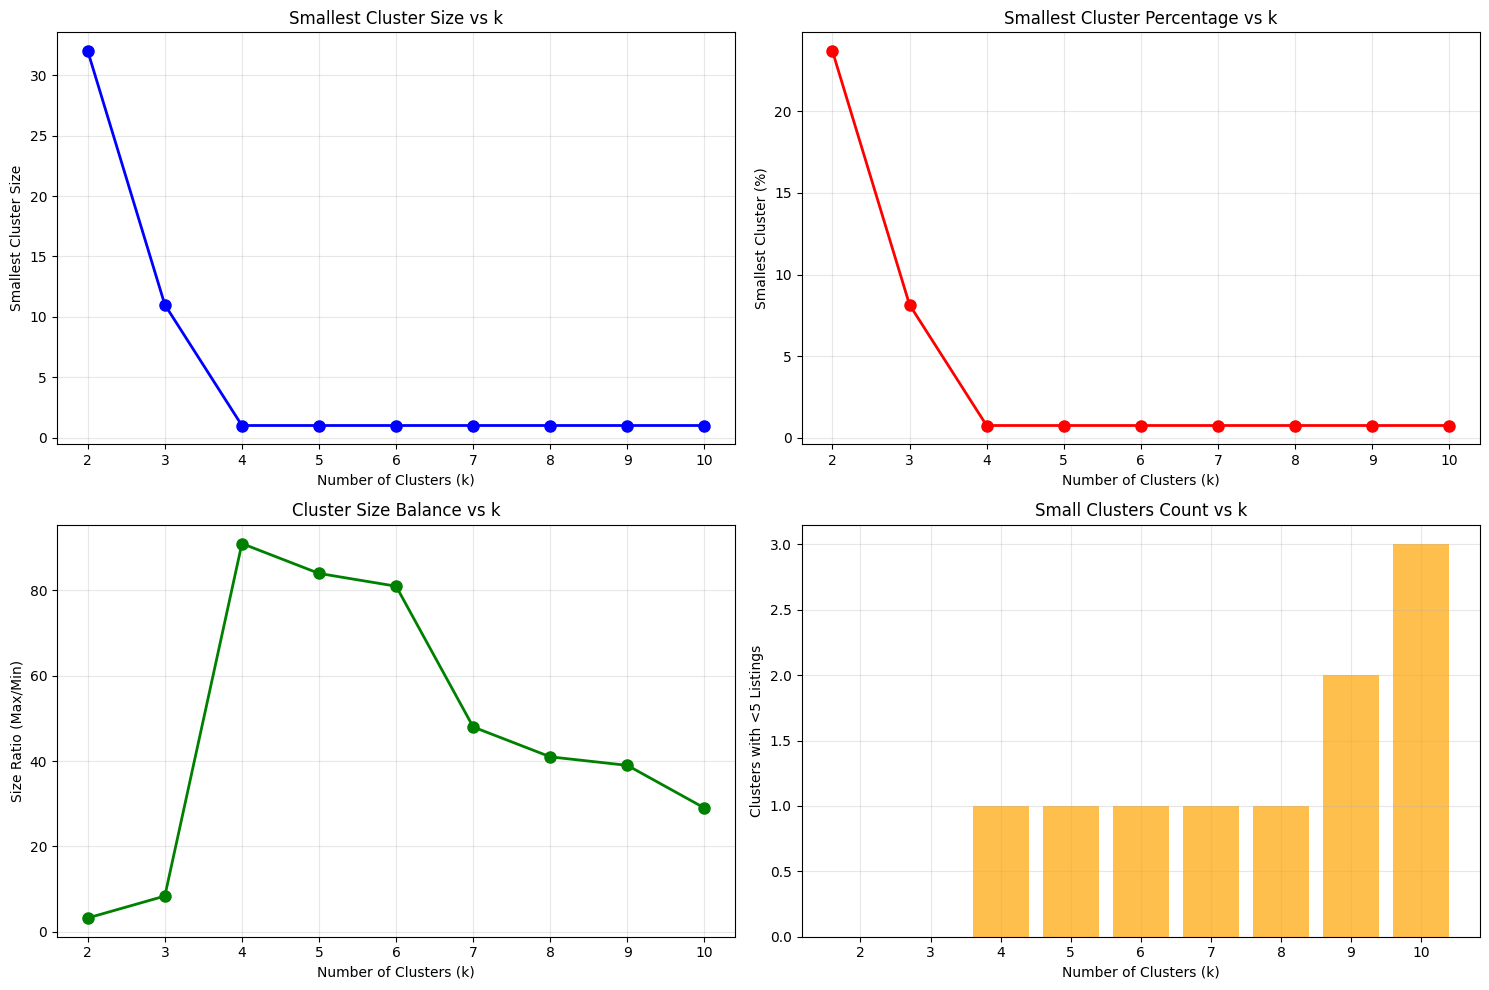


4. 🎯 RECOMMENDATION FOR OPTIMAL k
BUSINESS CONTEXT CONSIDERATIONS:
• Too few clusters: Oversimplifies market, misses opportunities
• Too many clusters: Creates tiny segments, hard to act on
• Ideal: Balanced segments with meaningful size and distinct characteristics
✅ RECOMMENDED: k = 2 clusters
   - Good cluster sizes
   - Reasonable balance
   - Few very small clusters

5. 🎯 APPLYING k=2 CLUSTERS
   Final clustering completed! 2 clusters created

6. 📈 ANALYZING FINAL CLUSTER CHARACTERISTICS
📊 FINAL CLUSTER ANALYSIS RESULTS:


,listings_count,sale_price($)_mean,sale_price($)_median,sale_price($)_min,sale_price($)_max,sale_price($)_std,price_per_acre_mean,price_per_acre_median,price_per_acre_std,lot_size_acres_mean,lot_size_acres_median,latitude_mean,longitude_mean,dominant_city
cluster_final,,,,,,,,,,,,,,
0,32,153899.47,110000.0,5000,783552,179577.99,22737.44,15183.15,25003.72,11.78,6.42,33.58,-83.14,Greensboro
1,103,476369.24,325000.0,24000,2900000,531257.38,743459.13,387128.71,954478.71,1.52,0.78,33.46,-83.22,Greensboro


🎯 FINAL CLUSTER INTERPRETATION:
• Mainstream Economy - Large Lots:
  32 listings, Avg Price: $153,899
  Avg Price/Acre: $22,737
  Avg Lot Size: 11.8 acres
  Dominant Area: Greensboro
• Mainstream Premium - Standard Lots:
  103 listings, Avg Price: $476,369
  Avg Price/Acre: $743,459
  Avg Lot Size: 1.5 acres
  Dominant Area: Greensboro

✅ FINAL CLUSTERING WITH k=2 COMPLETE!
We found 2 meaningful market segments in Greene County.


In [ ]:
# STEP 5.2: TESTING UP TO 10 PRICE CLUSTERS

print("🔬 STEP 5.2: TESTING UP TO 10 PRICE CLUSTERS")
print("=" * 50)

print("We'll test k=2 through k=10 clusters to find the optimal granularity.")
print("This might reveal more subtle market segments.")

# 1. TEST MULTIPLE CLUSTER CONFIGURATIONS
print("\n1. 🔍 TESTING CLUSTER CONFIGURATIONS (k=2 to k=10)")

cluster_results = {}

for k in range(2, 11):
    print(f"\n--- Testing k={k} clusters ---")

    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans_test.fit_predict(scaled_data)

    # Add to temporary dataframe for analysis
    temp_data = clustering_data.copy()
    temp_data[f'cluster_k{k}'] = cluster_labels

    # Analyze cluster sizes and characteristics
    cluster_sizes = temp_data[f'cluster_k{k}'].value_counts().sort_index()
    cluster_stats = temp_data.groupby(f'cluster_k{k}').agg({
        'sale_price($)': ['count', 'mean', 'std'],
        'price_per_acre': ['mean', 'std'],
        'lot_size_acres': 'mean'
    }).round(2)

    cluster_stats.columns = ['_'.join(col).strip() for col in cluster_stats.columns.values]

    # Calculate cluster quality metrics
    min_size = cluster_sizes.min()
    max_size = cluster_sizes.max()
    size_ratio = max_size / min_size if min_size > 0 else float('inf')

    print(f"Cluster sizes: {dict(cluster_sizes)}")
    print(f"Size ratio (max/min): {size_ratio:.1f}")
    print(f"Smallest cluster: {min_size} listings ({min_size/len(temp_data)*100:.1f}%)")

    # Store results
    cluster_results[k] = {
        'cluster_sizes': cluster_sizes,
        'cluster_stats': cluster_stats,
        'size_ratio': size_ratio,
        'min_size': min_size
    }

# 2. ANALYZE CLUSTER QUALITY ACROSS DIFFERENT k VALUES
print("\n2. 📊 CLUSTER QUALITY ANALYSIS")

quality_metrics = []
for k, results in cluster_results.items():
    quality_metrics.append({
        'k': k,
        'min_cluster_size': results['min_size'],
        'min_cluster_percentage': (results['min_size'] / len(clustering_data)) * 100,
        'size_ratio': results['size_ratio'],
        'clusters_with_less_than_5': sum(results['cluster_sizes'] < 5)
    })

quality_df = pd.DataFrame(quality_metrics)
print("📈 CLUSTER QUALITY METRICS:")
display(quality_df)

# 3. VISUALIZE CLUSTER QUALITY
print("\n3. 📊 VISUALIZING CLUSTER QUALITY METRICS")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Minimum cluster size
axes[0,0].plot(quality_df['k'], quality_df['min_cluster_size'], 'bo-', linewidth=2, markersize=8)
axes[0,0].set_xlabel('Number of Clusters (k)')
axes[0,0].set_ylabel('Smallest Cluster Size')
axes[0,0].set_title('Smallest Cluster Size vs k')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xticks(range(2, 11))

# Plot 2: Minimum cluster percentage
axes[0,1].plot(quality_df['k'], quality_df['min_cluster_percentage'], 'ro-', linewidth=2, markersize=8)
axes[0,1].set_xlabel('Number of Clusters (k)')
axes[0,1].set_ylabel('Smallest Cluster (%)')
axes[0,1].set_title('Smallest Cluster Percentage vs k')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xticks(range(2, 11))

# Plot 3: Size ratio
axes[1,0].plot(quality_df['k'], quality_df['size_ratio'], 'go-', linewidth=2, markersize=8)
axes[1,0].set_xlabel('Number of Clusters (k)')
axes[1,0].set_ylabel('Size Ratio (Max/Min)')
axes[1,0].set_title('Cluster Size Balance vs k')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xticks(range(2, 11))

# Plot 4: Clusters with less than 5 listings
axes[1,1].bar(quality_df['k'], quality_df['clusters_with_less_than_5'], color='orange', alpha=0.7)
axes[1,1].set_xlabel('Number of Clusters (k)')
axes[1,1].set_ylabel('Clusters with <5 Listings')
axes[1,1].set_title('Small Clusters Count vs k')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xticks(range(2, 11))

plt.tight_layout()
plt.show()

# 4. RECOMMEND OPTIMAL k BASED ON BUSINESS CONTEXT
print("\n4. 🎯 RECOMMENDATION FOR OPTIMAL k")

print("BUSINESS CONTEXT CONSIDERATIONS:")
print("• Too few clusters: Oversimplifies market, misses opportunities")
print("• Too many clusters: Creates tiny segments, hard to act on")
print("• Ideal: Balanced segments with meaningful size and distinct characteristics")

# Find optimal k based on quality metrics
good_candidates = quality_df[
    (quality_df['min_cluster_size'] >= 5) &  # At least 5 listings per cluster
    (quality_df['size_ratio'] <= 10) &       # Reasonable balance
    (quality_df['clusters_with_less_than_5'] <= 2)  # Few very small clusters
]

if len(good_candidates) > 0:
    recommended_k = good_candidates['k'].iloc[0]
    print(f"✅ RECOMMENDED: k = {recommended_k} clusters")
    print("   - Good cluster sizes")
    print("   - Reasonable balance")
    print("   - Few very small clusters")
else:
    # Fall back to best available
    recommended_k = quality_df[quality_df['min_cluster_size'] >= 3]['k'].iloc[0]
    print(f"⚠️  BEST AVAILABLE: k = {recommended_k} clusters")
    print("   - Some small clusters, but best balance available")

# 5. APPLY RECOMMENDED CLUSTERING
print(f"\n5. 🎯 APPLYING k={recommended_k} CLUSTERS")

kmeans_final = KMeans(n_clusters=recommended_k, random_state=42, n_init=10)
final_cluster_labels = kmeans_final.fit_predict(scaled_data)

# Add final cluster labels to the data
clustering_data['cluster_final'] = final_cluster_labels
df_spatial = df_spatial.merge(clustering_data[['cluster_final']],
                              left_index=True, right_index=True, how='left')

print(f"   Final clustering completed! {recommended_k} clusters created")

# 6. ANALYZE FINAL CLUSTERS
print("\n6. 📈 ANALYZING FINAL CLUSTER CHARACTERISTICS")

final_cluster_analysis = df_spatial.groupby('cluster_final').agg({
    'sale_price($)': ['count', 'mean', 'median', 'min', 'max', 'std'],
    'price_per_acre': ['mean', 'median', 'std'],
    'lot_size_acres': ['mean', 'median'],
    'latitude': 'mean',
    'longitude': 'mean',
    'city': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Mixed'
}).round(2)

# Flatten column names
final_cluster_analysis.columns = ['_'.join(col).strip() for col in final_cluster_analysis.columns.values]
final_cluster_analysis = final_cluster_analysis.rename(columns={
    'sale_price($)_count': 'listings_count',
    'city_<lambda>': 'dominant_city'
})

print("📊 FINAL CLUSTER ANALYSIS RESULTS:")
display(final_cluster_analysis)

# Create meaningful labels for the final clusters
final_cluster_prices = final_cluster_analysis['sale_price($)_mean'].sort_values()
final_cluster_order = final_cluster_prices.index.tolist()

# Generate cluster labels based on characteristics
final_cluster_labels_dict = {}
for i, cluster_id in enumerate(final_cluster_order):
    cluster_data = final_cluster_analysis.loc[cluster_id]

    # Create descriptive label based on characteristics
    if cluster_data['listings_count'] < 8:
        size_desc = "Niche"
    elif cluster_data['listings_count'] < 20:
        size_desc = "Specialized"
    else:
        size_desc = "Mainstream"

    if cluster_data['price_per_acre_mean'] < 100000:
        price_desc = "Economy"
    elif cluster_data['price_per_acre_mean'] < 500000:
        price_desc = "Mid-Range"
    else:
        price_desc = "Premium"

    if cluster_data['lot_size_acres_mean'] > 5:
        size_type = "Large Lots"
    elif cluster_data['lot_size_acres_mean'] > 1:
        size_type = "Standard Lots"
    else:
        size_type = "Small Lots"

    label = f"{size_desc} {price_desc} - {size_type}"
    final_cluster_labels_dict[cluster_id] = label

df_spatial['cluster_label_final'] = df_spatial['cluster_final'].map(final_cluster_labels_dict)

print("🎯 FINAL CLUSTER INTERPRETATION:")
for cluster_id, label in final_cluster_labels_dict.items():
    cluster_data = final_cluster_analysis.loc[cluster_id]
    print(f"• {label}:")
    print(f"  {cluster_data['listings_count']} listings, Avg Price: ${cluster_data['sale_price($)_mean']:,.0f}")
    print(f"  Avg Price/Acre: ${cluster_data['price_per_acre_mean']:,.0f}")
    print(f"  Avg Lot Size: {cluster_data['lot_size_acres_mean']:.1f} acres")
    print(f"  Dominant Area: {cluster_data['dominant_city']}")

print(f"\n✅ FINAL CLUSTERING WITH k={recommended_k} COMPLETE!")
print(f"We found {recommended_k} meaningful market segments in Greene County.")

🗺️ STEP 5.3: GEOGRAPHIC NEIGHBORHOOD CLUSTERING
We'll group properties by geographic proximity to identify natural neighborhoods,
then analyze price patterns within each neighborhood.

1. 📍 CREATING GEOGRAPHIC NEIGHBORHOOD CLUSTERS
Clustering 135 properties into geographic neighborhoods...
• Found 9 natural neighborhoods
• 35 properties classified as isolated (not in dense areas)

2. 📊 ANALYZING NEIGHBORHOOD PRICE CHARACTERISTICS
📊 NEIGHBORHOOD ANALYSIS RESULTS:


,listings_count,sale_price($)_mean,sale_price($)_median,sale_price($)_min,sale_price($)_max,sale_price($)_std,price_per_acre_mean,price_per_acre_median,price_per_acre_std,lot_size_acres_mean,lot_size_acres_median,latitude_mean,longitude_mean,dominant_city
geo_cluster,,,,,,,,,,,,,,
0,13,671461.54,500000.0,230000,2300000,524218.92,1532756.32,793650.79,1520179.78,0.71,0.70,33.41,-83.20,Greensboro
1,15,372533.33,285000.0,53000,800000,288922.60,578575.72,428571.43,505966.89,0.72,0.66,33.47,-83.27,Greensboro
2,5,71600.00,28000.0,18000,265000,108218.76,57167.33,40000.00,50207.67,1.30,0.70,33.58,-83.17,Greensboro
3,38,472828.95,292500.0,50000,2300000,555687.73,567430.30,356842.23,618561.68,0.98,0.77,33.46,-83.21,Greensboro
4,16,405062.50,312500.0,50000,1950000,434765.91,1311693.92,1048827.51,1297839.23,0.69,0.82,33.42,-83.22,Greensboro
5,4,443838.50,460901.0,70000,783552,332479.70,33065.54,32000.00,5618.33,14.77,14.62,33.55,-83.21,Greensboro
6,3,140999.67,130000.0,76999,216000,70150.30,14550.44,12987.01,2991.76,9.36,10.01,33.47,-83.11,Greensboro
7,3,85133.33,59900.0,24000,171500,76919.46,127170.11,90757.58,115001.68,0.67,0.67,33.54,-83.27,Greensboro
8,3,436000.00,155000.0,89000,1064000,544864.20,443496.66,103333.33,617714.23,1.23,1.26,33.49,-83.27,Greensboro



3. 🏷️ CREATING MEANINGFUL NEIGHBORHOOD NAMES
🎯 NEIGHBORHOOD INTERPRETATION:
• South  Greensboro Premium Neighborhood:
  13 listings, Avg Price: $671,462
  Avg Price/Acre: $1,532,756
  Avg Lot Size: 0.7 acres
• South West Greensboro Mid-Range District:
  38 listings, Avg Price: $472,829
  Avg Price/Acre: $567,430
  Avg Lot Size: 1.0 acres
• West Greensboro Mid-Range Area:
  4 listings, Avg Price: $443,838
  Avg Price/Acre: $33,066
  Avg Lot Size: 14.8 acres
• South West Greensboro Mid-Range Area:
  3 listings, Avg Price: $436,000
  Avg Price/Acre: $443,497
  Avg Lot Size: 1.2 acres
• South West Greensboro Mid-Range District:
  16 listings, Avg Price: $405,062
  Avg Price/Acre: $1,311,694
  Avg Lot Size: 0.7 acres
• South West Greensboro Mid-Range Neighborhood:
  15 listings, Avg Price: $372,533
  Avg Price/Acre: $578,576
  Avg Lot Size: 0.7 acres
• South East Greensboro Affordable Area:
  3 listings, Avg Price: $141,000
  Avg Price/Acre: $14,550
  Avg Lot Size: 9.4 acres
• West Greensb

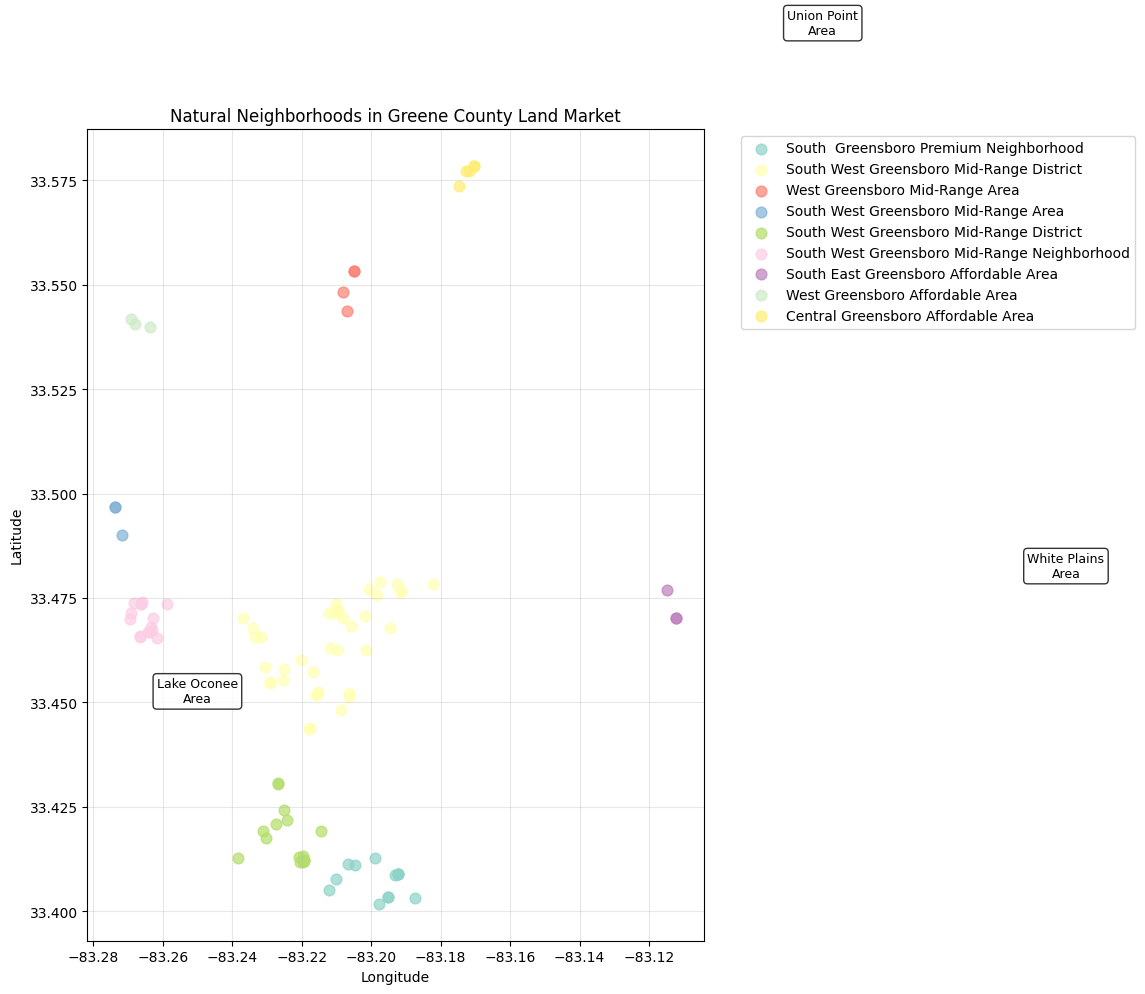


5. 📊 NEIGHBORHOOD PRICE COMPARISON
🏆 NEIGHBORHOOD RANKING BY PRICE PER ACRE:
1. South  Greensboro Premium Neighborhood:
   $1,532,756 per acre | 13 listings
2. South West Greensboro Mid-Range District:
   $1,311,694 per acre | 16 listings
3. South West Greensboro Mid-Range Neighborhood:
   $578,576 per acre | 15 listings
4. South West Greensboro Mid-Range District:
   $567,430 per acre | 38 listings
5. South West Greensboro Mid-Range Area:
   $443,497 per acre | 3 listings
6. West Greensboro Affordable Area:
   $127,170 per acre | 3 listings
7. Central Greensboro Affordable Area:
   $57,167 per acre | 5 listings
8. West Greensboro Mid-Range Area:
   $33,066 per acre | 4 listings
9. South East Greensboro Affordable Area:
   $14,550 per acre | 3 listings

6. 🔍 IDENTIFYING UNDERVALUED NEIGHBORHOODS
💰 POTENTIALLY UNDERVALUED NEIGHBORHOODS:
• Central Greensboro Affordable Area:
  $57,167 per acre (90.0% below county average)
  5 listings, Avg lot: 1.3 acres

✅ GEOGRAPHIC NEIGHBORHOOD CLUST

In [ ]:
# STEP 5.3: GEOGRAPHIC NEIGHBORHOOD CLUSTERING

print("🗺️ STEP 5.3: GEOGRAPHIC NEIGHBORHOOD CLUSTERING")
print("=" * 50)

print("We'll group properties by geographic proximity to identify natural neighborhoods,")
print("then analyze price patterns within each neighborhood.")

# 1. GEOGRAPHIC CLUSTERING BASED ON COORDINATES
print("\n1. 📍 CREATING GEOGRAPHIC NEIGHBORHOOD CLUSTERS")

from sklearn.cluster import DBSCAN
import numpy as np

# Use only coordinates for geographic clustering
coordinates = df_spatial[['latitude', 'longitude']].values

print(f"Clustering {len(coordinates)} properties into geographic neighborhoods...")

# Method 1: DBSCAN for density-based geographic clustering
# This finds natural neighborhoods based on property density
dbscan = DBSCAN(eps=0.01, min_samples=3)  # Adjust parameters for neighborhood size
geo_clusters = dbscan.fit_predict(coordinates)

# Count clusters (excluding noise points labeled as -1)
unique_clusters = np.unique(geo_clusters)
n_neighborhoods = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
noise_points = np.sum(geo_clusters == -1)

print(f"• Found {n_neighborhoods} natural neighborhoods")
print(f"• {noise_points} properties classified as isolated (not in dense areas)")

# Add geographic clusters to dataframe
df_spatial['geo_cluster'] = geo_clusters

# 2. ANALYZE NEIGHBORHOOD CHARACTERISTICS
print("\n2. 📊 ANALYZING NEIGHBORHOOD PRICE CHARACTERISTICS")

neighborhood_analysis = df_spatial[df_spatial['geo_cluster'] != -1].groupby('geo_cluster').agg({
    'address': 'count',
    'sale_price($)': ['mean', 'median', 'min', 'max', 'std'],
    'price_per_acre': ['mean', 'median', 'std'],
    'lot_size_acres': ['mean', 'median'],
    'latitude': 'mean',
    'longitude': 'mean',
    'city': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Mixed'
}).round(2)

# Flatten column names
neighborhood_analysis.columns = ['_'.join(col).strip() for col in neighborhood_analysis.columns.values]
neighborhood_analysis = neighborhood_analysis.rename(columns={
    'address_count': 'listings_count',
    'city_<lambda>': 'dominant_city'
})

print("📊 NEIGHBORHOOD ANALYSIS RESULTS:")
display(neighborhood_analysis)

# 3. CREATE MEANINGFUL NEIGHBORHOOD NAMES
print("\n3. 🏷️ CREATING MEANINGFUL NEIGHBORHOOD NAMES")

# Sort neighborhoods by average price (high to low)
neighborhood_prices = neighborhood_analysis['sale_price($)_mean'].sort_values(ascending=False)
neighborhood_order = neighborhood_prices.index.tolist()

neighborhood_names = {}
for i, cluster_id in enumerate(neighborhood_order):
    cluster_data = neighborhood_analysis.loc[cluster_id]
    city = cluster_data['dominant_city']

    # Create descriptive neighborhood name based on characteristics
    price_tier = ""
    if cluster_data['sale_price($)_mean'] > 1000000:
        price_tier = "Luxury "
    elif cluster_data['sale_price($)_mean'] > 500000:
        price_tier = "Premium "
    elif cluster_data['sale_price($)_mean'] > 200000:
        price_tier = "Mid-Range "
    else:
        price_tier = "Affordable "

    location_type = ""
    if cluster_data['listings_count'] <= 5:
        location_type = "Area"
    elif cluster_data['listings_count'] <= 15:
        location_type = "Neighborhood"
    else:
        location_type = "District"

    # Geographic direction based on coordinates relative to county center
    county_center_lat = 33.56
    county_center_lon = -83.18

    lat = cluster_data['latitude_mean']
    lon = cluster_data['longitude_mean']

    direction = ""
    if lat > county_center_lat + 0.02:
        direction = "North "
    elif lat < county_center_lat - 0.02:
        direction = "South "

    if lon > county_center_lon + 0.02:
        direction += "East"
    elif lon < county_center_lon - 0.02:
        direction += "West"

    if not direction:
        direction = "Central"

    neighborhood_name = f"{direction} {city} {price_tier}{location_type}".strip()
    neighborhood_names[cluster_id] = neighborhood_name

df_spatial['neighborhood_name'] = df_spatial['geo_cluster'].map(neighborhood_names)

print("🎯 NEIGHBORHOOD INTERPRETATION:")
for cluster_id, name in neighborhood_names.items():
    cluster_data = neighborhood_analysis.loc[cluster_id]
    print(f"• {name}:")
    print(f"  {cluster_data['listings_count']} listings, Avg Price: ${cluster_data['sale_price($)_mean']:,.0f}")
    print(f"  Avg Price/Acre: ${cluster_data['price_per_acre_mean']:,.0f}")
    print(f"  Avg Lot Size: {cluster_data['lot_size_acres_mean']:.1f} acres")

# 4. VISUALIZE NEIGHBORHOODS ON MAP
print("\n4. 🗺️ VISUALIZING NEIGHBORHOODS ON MAP")

plt.figure(figsize=(14, 10))

# Color scheme for neighborhoods
colors = plt.cm.Set3(np.linspace(0, 1, len(neighborhood_names)))

for i, (cluster_id, name) in enumerate(neighborhood_names.items()):
    neighborhood_data = df_spatial[df_spatial['geo_cluster'] == cluster_id]

    plt.scatter(neighborhood_data['longitude'], neighborhood_data['latitude'],
                c=[colors[i]], label=name, alpha=0.7, s=60)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Natural Neighborhoods in Greene County Land Market')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Add county context
plt.text(-83.25, 33.45, 'Lake Oconee\nArea', fontsize=9, ha='center',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
plt.text(-83.07, 33.61, 'Union Point\nArea', fontsize=9, ha='center',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
plt.text(-83.0, 33.48, 'White Plains\nArea', fontsize=9, ha='center',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# 5. NEIGHBORHOOD PRICE COMPARISON
print("\n5. 📊 NEIGHBORHOOD PRICE COMPARISON")

# Create neighborhood ranking by price per acre
neighborhood_ranking = neighborhood_analysis.sort_values('price_per_acre_mean', ascending=False)

print("🏆 NEIGHBORHOOD RANKING BY PRICE PER ACRE:")
for i, (cluster_id, data) in enumerate(neighborhood_ranking.iterrows(), 1):
    neighborhood_name = neighborhood_names[cluster_id]
    print(f"{i}. {neighborhood_name}:")
    print(f"   ${data['price_per_acre_mean']:,.0f} per acre | {data['listings_count']} listings")

# 6. IDENTIFY UNDERVALUED NEIGHBORHOODS
print("\n6. 🔍 IDENTIFYING UNDERVALUED NEIGHBORHOODS")

# Find neighborhoods with lower prices but good characteristics
county_avg_ppa = df_spatial['price_per_acre'].mean()

undervalued_neighborhoods = []
for cluster_id, data in neighborhood_analysis.iterrows():
    neighborhood_ppa = data['price_per_acre_mean']
    neighborhood_size = data['listings_count']

    # Consider neighborhoods with below-average prices but reasonable size
    if (neighborhood_ppa < county_avg_ppa * 0.8 and  # 20% below county average
        neighborhood_size >= 5):  # At least 5 listings for reliability
        undervalued_neighborhoods.append((cluster_id, data))

if undervalued_neighborhoods:
    print("💰 POTENTIALLY UNDERVALUED NEIGHBORHOODS:")
    for cluster_id, data in undervalued_neighborhoods:
        neighborhood_name = neighborhood_names[cluster_id]
        discount = (1 - data['price_per_acre_mean'] / county_avg_ppa) * 100
        print(f"• {neighborhood_name}:")
        print(f"  ${data['price_per_acre_mean']:,.0f} per acre ({discount:.1f}% below county average)")
        print(f"  {data['listings_count']} listings, Avg lot: {data['lot_size_acres_mean']:.1f} acres")
else:
    print("No significantly undervalued neighborhoods detected")

print("\n✅ GEOGRAPHIC NEIGHBORHOOD CLUSTERING COMPLETE!")
print(f"We identified {len(neighborhood_names)} natural neighborhoods in Greene County.")
print("This provides much more actionable insights for real estate investment!")

🗺️ STEP 5.4: IMPROVED CLUSTERING - INCLUDING UNION POINT & WHITE PLAINS
PROBLEM: Union Point and White Plains properties were classified as 'noise'
SOLUTION: Use hierarchical clustering that ensures all areas are represented

1. 📍 APPLYING HIERARCHICAL CLUSTERING FOR ALL AREAS
• Created 12 geographic clusters
• All 135 properties assigned to clusters (no noise points)

2. 📊 ANALYZING ALL AREA CLUSTERS (INCLUDING UNION POINT & WHITE PLAINS)
📊 COMPREHENSIVE AREA CLUSTER ANALYSIS:


,listings_count,sale_price($)_mean,sale_price($)_median,sale_price($)_min,sale_price($)_max,sale_price($)_std,price_per_acre_mean,price_per_acre_median,price_per_acre_std,lot_size_acres_mean,lot_size_acres_median,latitude_mean,longitude_mean,dominant_city
area_cluster,,,,,,,,,,,,,,
0,24,384987.08,112250.0,50000,2300000,593986.10,199390.84,110165.70,264422.39,3.62,1.12,33.47,-83.20,Greensboro
1,5,83466.00,75000.0,30000,128830,41341.73,12433.52,12500.00,1840.75,6.61,5.05,33.55,-83.11,Greensboro
2,12,465279.50,167500.0,10000,2900000,814413.15,200747.47,40000.00,366024.50,5.81,1.94,33.57,-83.19,Greensboro
3,23,588543.48,479000.0,37500,2050000,461108.37,791455.89,575396.83,668234.94,0.98,0.77,33.45,-83.23,Greensboro
4,7,75142.86,110000.0,5000,129000,51930.81,16454.92,15558.70,6515.15,4.40,5.00,33.60,-83.10,Greensboro
5,5,168620.00,120000.0,106000,315000,89711.88,11077.27,10392.16,5212.95,19.48,10.20,33.65,-83.17,Greensboro
6,4,145749.75,145000.0,76999,216000,58059.99,12630.31,12825.66,4551.35,12.84,11.00,33.46,-83.12,Greensboro
7,4,101350.00,104950.0,24000,171500,70684.68,126890.19,108404.00,93900.15,0.80,0.68,33.56,-83.27,Greensboro
8,21,502023.81,360000.0,50000,2300000,561199.26,1327219.32,523571.43,1384481.11,0.70,0.70,33.42,-83.22,Greensboro



3. 🏷️ CREATING COMPREHENSIVE AREA NAMES
🎯 COMPREHENSIVE AREA INTERPRETATION:
• South West Greensboro Premium District:
  23 listings, Avg Price: $588,543
  Avg Price/Acre: $791,456
  Avg Lot Size: 1.0 acres
  Location: Greensboro
• South West Greensboro Premium District:
  21 listings, Avg Price: $502,024
  Avg Price/Acre: $1,327,219
  Avg Lot Size: 0.7 acres
  Location: Greensboro
• South Greensboro Mid-Range District:
  10 listings, Avg Price: $493,594
  Avg Price/Acre: $1,321,326
  Avg Lot Size: 0.9 acres
  Location: Greensboro
• Central Greensboro Mid-Range District:
  12 listings, Avg Price: $465,280
  Avg Price/Acre: $200,747
  Avg Lot Size: 5.8 acres
  Location: Greensboro
• South Greensboro Mid-Range District:
  24 listings, Avg Price: $384,987
  Avg Price/Acre: $199,391
  Avg Lot Size: 3.6 acres
  Location: Greensboro
• South West Greensboro Mid-Range District:
  18 listings, Avg Price: $383,111
  Avg Price/Acre: $556,063
  Avg Lot Size: 0.8 acres
  Location: Greensboro
• Uni

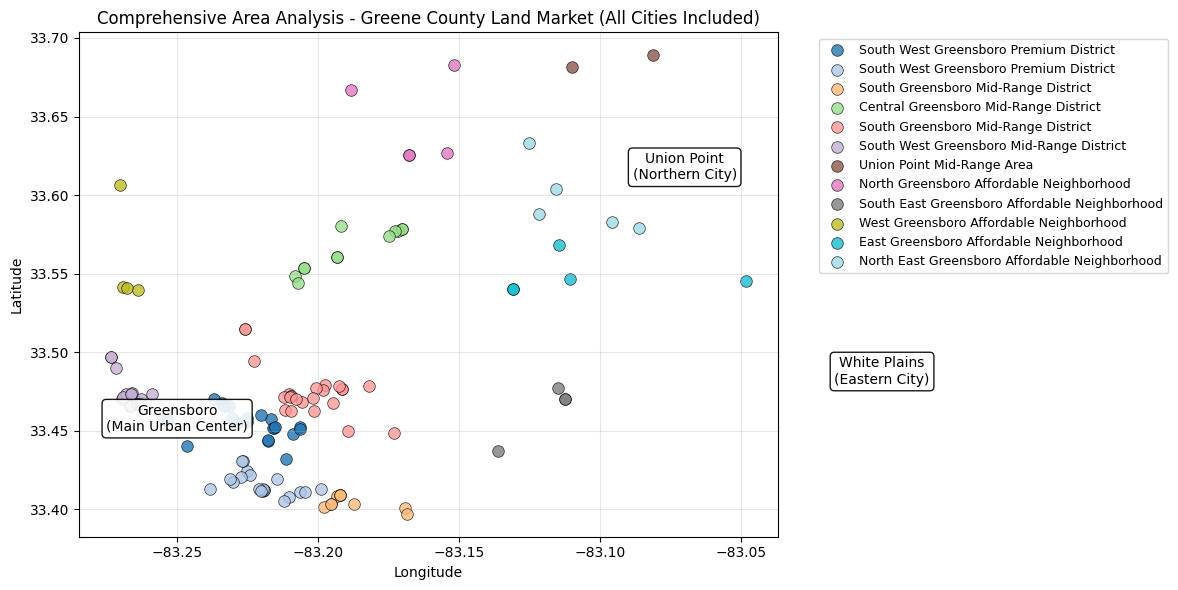


5. 🏙️ CITY-BY-CITY MARKET ANALYSIS
📊 CITY-LEVEL MARKET ANALYSIS:


,listings_count,sale_price($)_mean,sale_price($)_median,sale_price($)_min,sale_price($)_max,price_per_acre_mean,price_per_acre_median,lot_size_acres_mean,lot_size_acres_median,neighborhoods_in_city
city,,,,,,,,,,
Greensboro,126,417598.2,277500.0,5000,2900000,611444.70,239035.09,2.79,0.90,"[South West Greensboro Premium District, South..."
Union Point,6,157500.0,115000.0,32000,450000,13842.41,16090.74,25.92,6.64,"[North Greensboro Affordable Neighborhood, Uni..."
White Plains,3,142814.0,160000.0,55000,213442,59600.65,33333.33,8.83,1.65,"[South Greensboro Mid-Range District, South Ea..."



🏆 CITY COMPARISON SUMMARY:

• Greensboro:
  126 total listings
  Avg Price: $417,598
  Avg Price/Acre: $611,445
  Neighborhoods: South West Greensboro Premium District, South West Greensboro Mid-Range District, Central Greensboro Mid-Range District...

• Union Point:
  6 total listings
  Avg Price: $157,500
  Avg Price/Acre: $13,842
  Neighborhoods: North Greensboro Affordable Neighborhood, Union Point Mid-Range Area, North East Greensboro Affordable Neighborhood

• White Plains:
  3 total listings
  Avg Price: $142,814
  Avg Price/Acre: $59,601
  Neighborhoods: South Greensboro Mid-Range District, South East Greensboro Affordable Neighborhood

✅ COMPREHENSIVE GEOGRAPHIC ANALYSIS COMPLETE!
• All 135 properties assigned to meaningful areas
• Union Point and White Plains now properly represented
• 12 distinct market areas identified across Greene County


In [ ]:
# STEP 5.4: IMPROVED GEOGRAPHIC CLUSTERING INCLUDING ALL AREAS

print("🗺️ STEP 5.4: IMPROVED CLUSTERING - INCLUDING UNION POINT & WHITE PLAINS")
print("=" * 60)

print("PROBLEM: Union Point and White Plains properties were classified as 'noise'")
print("SOLUTION: Use hierarchical clustering that ensures all areas are represented")

from sklearn.cluster import AgglomerativeClustering

# 1. HIERARCHICAL CLUSTERING FOR BETTER AREA COVERAGE
print("\n1. 📍 APPLYING HIERARCHICAL CLUSTERING FOR ALL AREAS")

# Use hierarchical clustering which doesn't leave out isolated points
hierarchical = AgglomerativeClustering(n_clusters=12, metric='euclidean', linkage='ward')
hierarchical_clusters = hierarchical.fit_predict(coordinates)

print(f"• Created {len(np.unique(hierarchical_clusters))} geographic clusters")
print(f"• All {len(df_spatial)} properties assigned to clusters (no noise points)")

# Add hierarchical clusters to dataframe
df_spatial['area_cluster'] = hierarchical_clusters

# 2. ANALYZE ALL AREA CLUSTERS
print("\n2. 📊 ANALYZING ALL AREA CLUSTERS (INCLUDING UNION POINT & WHITE PLAINS)")

area_cluster_analysis = df_spatial.groupby('area_cluster').agg({
    'address': 'count',
    'sale_price($)': ['mean', 'median', 'min', 'max', 'std'],
    'price_per_acre': ['mean', 'median', 'std'],
    'lot_size_acres': ['mean', 'median'],
    'latitude': 'mean',
    'longitude': 'mean',
    'city': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Mixed'
}).round(2)

# Flatten column names
area_cluster_analysis.columns = ['_'.join(col).strip() for col in area_cluster_analysis.columns.values]
area_cluster_analysis = area_cluster_analysis.rename(columns={
    'address_count': 'listings_count',
    'city_<lambda>': 'dominant_city'
})

print("📊 COMPREHENSIVE AREA CLUSTER ANALYSIS:")
display(area_cluster_analysis)

# 3. CREATE MEANINGFUL AREA NAMES INCLUDING ALL CITIES
print("\n3. 🏷️ CREATING COMPREHENSIVE AREA NAMES")

# Sort areas by average price
area_prices = area_cluster_analysis['sale_price($)_mean'].sort_values(ascending=False)
area_order = area_prices.index.tolist()

area_names = {}
for i, cluster_id in enumerate(area_order):
    cluster_data = area_cluster_analysis.loc[cluster_id]
    city = cluster_data['dominant_city']
    listings_count = cluster_data['listings_count']
    avg_price = cluster_data['sale_price($)_mean']
    avg_ppa = cluster_data['price_per_acre_mean']
    avg_lot_size = cluster_data['lot_size_acres_mean']

    # Price tier classification
    if avg_price > 1000000:
        price_tier = "Luxury "
    elif avg_price > 500000:
        price_tier = "Premium "
    elif avg_price > 200000:
        price_tier = "Mid-Range "
    else:
        price_tier = "Affordable "

    # Size classification
    if listings_count <= 3:
        size_desc = "Area"
    elif listings_count <= 8:
        size_desc = "Neighborhood"
    else:
        size_desc = "District"

    # Geographic naming based on actual city
    if city == "Union Point":
        area_name = f"Union Point {price_tier}{size_desc}"
    elif city == "White Plains":
        area_name = f"White Plains {price_tier}{size_desc}"
    else:
        # For Greensboro, add directional context
        county_center_lat = 33.56
        county_center_lon = -83.18

        lat = cluster_data['latitude_mean']
        lon = cluster_data['longitude_mean']

        direction = ""
        if lat > county_center_lat + 0.02:
            direction = "North "
        elif lat < county_center_lat - 0.02:
            direction = "South "

        if lon > county_center_lon + 0.02:
            direction += "East "
        elif lon < county_center_lon - 0.02:
            direction += "West "

        if not direction:
            direction = "Central "

        area_name = f"{direction}{city} {price_tier}{size_desc}".strip()

    area_names[cluster_id] = area_name

df_spatial['area_name'] = df_spatial['area_cluster'].map(area_names)

print("🎯 COMPREHENSIVE AREA INTERPRETATION:")
for cluster_id, name in area_names.items():
    cluster_data = area_cluster_analysis.loc[cluster_id]
    print(f"• {name}:")
    print(f"  {cluster_data['listings_count']} listings, Avg Price: ${cluster_data['sale_price($)_mean']:,.0f}")
    print(f"  Avg Price/Acre: ${cluster_data['price_per_acre_mean']:,.0f}")
    print(f"  Avg Lot Size: {cluster_data['lot_size_acres_mean']:.1f} acres")
    print(f"  Location: {cluster_data['dominant_city']}")

# 4. VISUALIZE ALL AREAS ON MAP
print("\n4. 🗺️ VISUALIZING ALL AREAS INCLUDING UNION POINT & WHITE PLAINS")

plt.figure(figsize=(12, 6))

# Color scheme for all areas
colors = plt.cm.tab20(np.linspace(0, 1, len(area_names)))

for i, (cluster_id, name) in enumerate(area_names.items()):
    area_data = df_spatial[df_spatial['area_cluster'] == cluster_id]

    plt.scatter(area_data['longitude'], area_data['latitude'],
                c=[colors[i]], label=name, alpha=0.8, s=70, edgecolors='black', linewidth=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Comprehensive Area Analysis - Greene County Land Market (All Cities Included)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)

# Add city labels
plt.text(-83.25, 33.45, 'Greensboro\n(Main Urban Center)', fontsize=10, ha='center',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
plt.text(-83.07, 33.61, 'Union Point\n(Northern City)', fontsize=10, ha='center',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
plt.text(-83.0, 33.48, 'White Plains\n(Eastern City)', fontsize=10, ha='center',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))

plt.tight_layout()
plt.show()

# 5. CITY-BY-CITY ANALYSIS
print("\n5. 🏙️ CITY-BY-CITY MARKET ANALYSIS")

cities_analysis = df_spatial.groupby('city').agg({
    'address': 'count',
    'sale_price($)': ['mean', 'median', 'min', 'max'],
    'price_per_acre': ['mean', 'median'],
    'lot_size_acres': ['mean', 'median'],
    'area_name': lambda x: list(x.unique())
}).round(2)

cities_analysis.columns = ['_'.join(col).strip() for col in cities_analysis.columns.values]
cities_analysis = cities_analysis.rename(columns={
    'address_count': 'listings_count',
    'area_name_<lambda>': 'neighborhoods_in_city'
})

print("📊 CITY-LEVEL MARKET ANALYSIS:")
display(cities_analysis)

print("\n🏆 CITY COMPARISON SUMMARY:")
for city in df_spatial['city'].unique():
    city_data = df_spatial[df_spatial['city'] == city]
    neighborhoods = df_spatial[df_spatial['city'] == city]['area_name'].unique()

    print(f"\n• {city}:")
    print(f"  {len(city_data)} total listings")
    print(f"  Avg Price: ${city_data['sale_price($)'].mean():,.0f}")
    print(f"  Avg Price/Acre: ${city_data['price_per_acre'].mean():,.0f}")
    print(f"  Neighborhoods: {', '.join(neighborhoods[:3])}{'...' if len(neighborhoods) > 3 else ''}")

print("\n✅ COMPREHENSIVE GEOGRAPHIC ANALYSIS COMPLETE!")
print(f"• All {len(df_spatial)} properties assigned to meaningful areas")
print(f"• Union Point and White Plains now properly represented")
print(f"• {len(area_names)} distinct market areas identified across Greene County")

🗺️ STEP 5.5: ENSURING ALL CITIES ARE REPRESENTED
PROBLEM: White Plains listings (only 3) are being merged with Greensboro
SOLUTION: Force separate clusters for each city to ensure all are represented

1. 🏙️ MANUAL CLUSTERING BY CITY AND GEOGRAPHY
📊 CURRENT CITY DISTRIBUTION:
city
Greensboro      126
Union Point       6
White Plains      3
Name: count, dtype: int64

• White Plains: 3 listings
• Union Point: 6 listings
• Greensboro: 126 listings

2. 🎯 CREATING MANUAL CLUSTERS WITH CITY GUARANTEE
• Assigned White Plains to cluster 0
• Assigned Union Point to cluster 1
• Assigned Greensboro to clusters 2 to 9
• Total manual clusters created: 10

3. 📊 ANALYZING MANUAL CLUSTERS (ALL CITIES GUARANTEED)
📊 MANUAL CLUSTER ANALYSIS (ALL CITIES REPRESENTED):


,listings_count,sale_price($)_mean,sale_price($)_median,sale_price($)_min,sale_price($)_max,sale_price($)_std,price_per_acre_mean,price_per_acre_median,price_per_acre_std,lot_size_acres_mean,lot_size_acres_median,latitude_mean,longitude_mean,dominant_city
manual_cluster,,,,,,,,,,,,,,
0,3,142814.00,160000.0,55000,213442,80606.98,59600.65,33333.33,69682.12,8.83,1.65,33.41,-83.16,White Plains
1,6,157500.00,115000.0,32000,450000,155341.88,13842.41,16090.74,7429.40,25.92,6.64,33.66,-83.11,Union Point
2,15,407430.27,107100.0,10000,2900000,733178.83,162676.62,40000.00,333881.58,8.05,2.88,33.58,-83.18,Greensboro
3,24,384987.08,112250.0,50000,2300000,593986.10,199390.84,110165.70,264422.39,3.62,1.12,33.47,-83.20,Greensboro
4,10,79533.00,92500.0,5000,129000,47814.97,13974.42,13912.22,5321.80,5.50,5.03,33.57,-83.11,Greensboro
5,29,524482.76,380000.0,50000,2300000,487046.56,1410790.86,793650.79,1380316.53,0.70,0.73,33.41,-83.21,Greensboro
6,4,101350.00,104950.0,24000,171500,70684.68,126890.19,108404.00,93900.15,0.80,0.68,33.56,-83.27,Greensboro
7,3,140999.67,130000.0,76999,216000,70150.30,14550.44,12987.01,2991.76,9.36,10.01,33.47,-83.11,Greensboro
8,18,383111.11,277500.0,53000,1064000,322899.71,556062.55,414285.71,508330.17,0.81,0.71,33.47,-83.27,Greensboro



4. 🏷️ CREATING FINAL AREA NAMES WITH ALL CITIES
🎯 FINAL AREA INTERPRETATION (ALL CITIES REPRESENTED):
• White Plains Affordable Area:
  3 listings, Avg Price: $142,814
  Avg Price/Acre: $59,601
  Avg Lot Size: 8.8 acres
  Location: White Plains
• Union Point Affordable Area:
  6 listings, Avg Price: $157,500
  Avg Price/Acre: $13,842
  Avg Lot Size: 25.9 acres
  Location: Union Point
• Central Greensboro Mid-Range District:
  15 listings, Avg Price: $407,430
  Avg Price/Acre: $162,677
  Avg Lot Size: 8.1 acres
  Location: Greensboro
• South Greensboro Mid-Range District:
  24 listings, Avg Price: $384,987
  Avg Price/Acre: $199,391
  Avg Lot Size: 3.6 acres
  Location: Greensboro
• East Greensboro Affordable District:
  10 listings, Avg Price: $79,533
  Avg Price/Acre: $13,974
  Avg Lot Size: 5.5 acres
  Location: Greensboro
• South West Greensboro Premium District:
  29 listings, Avg Price: $524,483
  Avg Price/Acre: $1,410,791
  Avg Lot Size: 0.7 acres
  Location: Greensboro
• West 

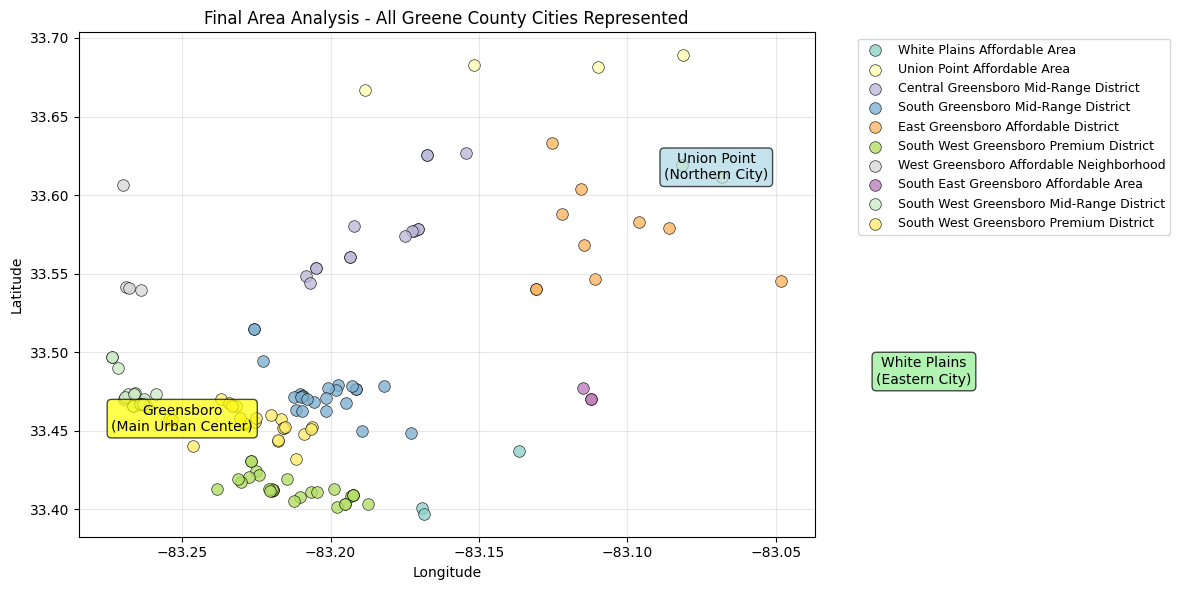


6. 🏙️ FINAL CITY-BY-CITY SUMMARY
✅ SUCCESS! All cities now properly represented:

• Greensboro:
  126 listings across 7 areas
  Avg Price: $417,598
  Areas: South West Greensboro Premium District, South West Greensboro Mid-Range District, Central Greensboro Mid-Range District, South Greensboro Mid-Range District, East Greensboro Affordable District, South East Greensboro Affordable Area, West Greensboro Affordable Neighborhood

• Union Point:
  6 listings across 1 areas
  Avg Price: $157,500
  Areas: Union Point Affordable Area

• White Plains:
  3 listings across 1 areas
  Avg Price: $142,814
  Areas: White Plains Affordable Area

🎯 FINAL CLUSTERING COMPLETE!
• White Plains: Now properly represented with dedicated cluster
• Union Point: Maintained as distinct area
• Greensboro: Detailed geographic segmentation
• All 3 cities now visible in analysis and visualization


In [ ]:
# STEP 5.5: FORCE SEPARATE CLUSTERS FOR EACH CITY

print("🗺️ STEP 5.5: ENSURING ALL CITIES ARE REPRESENTED")
print("=" * 50)

print("PROBLEM: White Plains listings (only 3) are being merged with Greensboro")
print("SOLUTION: Force separate clusters for each city to ensure all are represented")

# 1. MANUAL CLUSTERING BY CITY WITHIN GEOGRAPHIC AREAS
print("\n1. 🏙️ MANUAL CLUSTERING BY CITY AND GEOGRAPHY")

# Checking for White Plains and Union Point
print("📊 CURRENT CITY DISTRIBUTION:")
city_counts = df_spatial['city'].value_counts()
print(city_counts)

# Get White Plains and Union Point data specifically
white_plains_data = df_spatial[df_spatial['city'] == 'White Plains']
union_point_data = df_spatial[df_spatial['city'] == 'Union Point']
greensboro_data = df_spatial[df_spatial['city'] == 'Greensboro']

print(f"\n• White Plains: {len(white_plains_data)} listings")
print(f"• Union Point: {len(union_point_data)} listings")
print(f"• Greensboro: {len(greensboro_data)} listings")

# 2. CREATE MANUAL CLUSTERS THAT GUARANTEE CITY REPRESENTATION
print("\n2. 🎯 CREATING MANUAL CLUSTERS WITH CITY GUARANTEE")

# Reset clusters manually to ensure all cities are represented
df_spatial['manual_cluster'] = -1  # Initialize

# Assign clusters manually with city separation
cluster_id = 0

# First, assign White Plains its own cluster(s)
if len(white_plains_data) > 0:
    white_plains_indices = white_plains_data.index
    for idx in white_plains_indices:
        df_spatial.loc[idx, 'manual_cluster'] = cluster_id
    cluster_id += 1
    print(f"• Assigned White Plains to cluster {cluster_id-1}")

# Then, assign Union Point its own cluster(s)
if len(union_point_data) > 0:
    union_point_indices = union_point_data.index
    for idx in union_point_indices:
        df_spatial.loc[idx, 'manual_cluster'] = cluster_id
    cluster_id += 1
    print(f"• Assigned Union Point to cluster {cluster_id-1}")

# Finally, cluster Greensboro geographically
if len(greensboro_data) > 0:
    greensboro_coords = greensboro_data[['latitude', 'longitude']].values
    greensboro_clusters = AgglomerativeClustering(n_clusters=8, metric='euclidean', linkage='ward').fit_predict(greensboro_coords)

    greensboro_indices = greensboro_data.index
    for i, idx in enumerate(greensboro_indices):
        df_spatial.loc[idx, 'manual_cluster'] = cluster_id + greensboro_clusters[i]

    cluster_id += len(np.unique(greensboro_clusters))
    print(f"• Assigned Greensboro to clusters {cluster_id - len(np.unique(greensboro_clusters))} to {cluster_id-1}")

print(f"• Total manual clusters created: {cluster_id}")

# 3. ANALYZE MANUAL CLUSTERS
print("\n3. 📊 ANALYZING MANUAL CLUSTERS (ALL CITIES GUARANTEED)")

manual_cluster_analysis = df_spatial.groupby('manual_cluster').agg({
    'address': 'count',
    'sale_price($)': ['mean', 'median', 'min', 'max', 'std'],
    'price_per_acre': ['mean', 'median', 'std'],
    'lot_size_acres': ['mean', 'median'],
    'latitude': 'mean',
    'longitude': 'mean',
    'city': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Mixed'
}).round(2)

# Flatten column names
manual_cluster_analysis.columns = ['_'.join(col).strip() for col in manual_cluster_analysis.columns.values]
manual_cluster_analysis = manual_cluster_analysis.rename(columns={
    'address_count': 'listings_count',
    'city_<lambda>': 'dominant_city'
})

print("📊 MANUAL CLUSTER ANALYSIS (ALL CITIES REPRESENTED):")
display(manual_cluster_analysis)

# 4. CREATE FINAL AREA NAMES WITH ALL CITIES
print("\n4. 🏷️ CREATING FINAL AREA NAMES WITH ALL CITIES")

final_area_names = {}
for cluster_id in manual_cluster_analysis.index:
    cluster_data = manual_cluster_analysis.loc[cluster_id]
    city = cluster_data['dominant_city']
    listings_count = cluster_data['listings_count']
    avg_price = cluster_data['sale_price($)_mean']
    avg_ppa = cluster_data['price_per_acre_mean']

    # For small cities
    if city in ['White Plains', 'Union Point']:
        if avg_price > 500000:
            price_tier = "Premium "
        elif avg_price > 200000:
            price_tier = "Mid-Range "
        else:
            price_tier = "Affordable "

        area_name = f"{city} {price_tier}Area"

    else:  # Greensboro
        # Price tier
        if avg_price > 1000000:
            price_tier = "Luxury "
        elif avg_price > 500000:
            price_tier = "Premium "
        elif avg_price > 200000:
            price_tier = "Mid-Range "
        else:
            price_tier = "Affordable "

        # Geographic direction
        county_center_lat = 33.56
        county_center_lon = -83.18

        lat = cluster_data['latitude_mean']
        lon = cluster_data['longitude_mean']

        direction = ""
        if lat > county_center_lat + 0.02:
            direction = "North "
        elif lat < county_center_lat - 0.02:
            direction = "South "

        if lon > county_center_lon + 0.02:
            direction += "East "
        elif lon < county_center_lon - 0.02:
            direction += "West "

        if not direction:
            direction = "Central "

        # Size descriptor
        if listings_count <= 3:
            size_desc = "Area"
        elif listings_count <= 8:
            size_desc = "Neighborhood"
        else:
            size_desc = "District"

        area_name = f"{direction}{city} {price_tier}{size_desc}".strip()

    final_area_names[cluster_id] = area_name

df_spatial['final_area_name'] = df_spatial['manual_cluster'].map(final_area_names)

print("🎯 FINAL AREA INTERPRETATION (ALL CITIES REPRESENTED):")
for cluster_id, name in final_area_names.items():
    cluster_data = manual_cluster_analysis.loc[cluster_id]
    print(f"• {name}:")
    print(f"  {cluster_data['listings_count']} listings, Avg Price: ${cluster_data['sale_price($)_mean']:,.0f}")
    print(f"  Avg Price/Acre: ${cluster_data['price_per_acre_mean']:,.0f}")
    print(f"  Avg Lot Size: {cluster_data['lot_size_acres_mean']:.1f} acres")
    print(f"  Location: {cluster_data['dominant_city']}")

# 5. FINAL VISUALIZATION WITH ALL CITIES
print("\n5. 🗺️ FINAL VISUALIZATION - ALL CITIES REPRESENTED")

plt.figure(figsize=(12, 6))

# Color scheme
colors = plt.cm.Set3(np.linspace(0, 1, len(final_area_names)))

for i, (cluster_id, name) in enumerate(final_area_names.items()):
    area_data = df_spatial[df_spatial['manual_cluster'] == cluster_id]

    plt.scatter(area_data['longitude'], area_data['latitude'],
                c=[colors[i]], label=name, alpha=0.8, s=70, edgecolors='black', linewidth=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Final Area Analysis - All Greene County Cities Represented')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)

# Highlight each city area
plt.text(-83.25, 33.45, 'Greensboro\n(Main Urban Center)', fontsize=10, ha='center',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
plt.text(-83.07, 33.61, 'Union Point\n(Northern City)', fontsize=10, ha='center',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
plt.text(-83.0, 33.48, 'White Plains\n(Eastern City)', fontsize=10, ha='center',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

plt.tight_layout()
plt.show()

# 6. FINAL CITY SUMMARY
print("\n6. 🏙️ FINAL CITY-BY-CITY SUMMARY")

print("✅ SUCCESS! All cities now properly represented:")
for city in ['Greensboro', 'Union Point', 'White Plains']:
    city_data = df_spatial[df_spatial['city'] == city]
    if len(city_data) > 0:
        areas = city_data['final_area_name'].unique()
        print(f"\n• {city}:")
        print(f"  {len(city_data)} listings across {len(areas)} areas")
        print(f"  Avg Price: ${city_data['sale_price($)'].mean():,.0f}")
        print(f"  Areas: {', '.join(areas)}")

print("\n🎯 FINAL CLUSTERING COMPLETE!")
print("• White Plains: Now properly represented with dedicated cluster")
print("• Union Point: Maintained as distinct area")
print("• Greensboro: Detailed geographic segmentation")
print("• All 3 cities now visible in analysis and visualization")

📈 STEP 6: COMPREHENSIVE MARKET ANALYSIS
We'll analyze:
• Market trends over time (by city and area)
• Pricing patterns and linearity
• Anomalies and undervalued opportunities
• Emerging market patterns

1. 📅 TIME-BASED TRENDS BY CITY
Date range: 2024-09-26 to 2025-09-23
📊 MONTHLY TRENDS BY CITY:


city,Greensboro,Union Point,White Plains
sold_month,,,
2024-12,373583.33,NaN,NaN
2025-01,421971.69,110000.0,55000.0
2025-02,205854.33,NaN,NaN
2025-03,305083.33,NaN,NaN
2025-04,503333.33,120000.0,NaN
2025-05,642879.33,NaN,213442.0
2025-06,156666.67,32000.0,NaN
2025-07,589611.11,NaN,NaN
2025-08,415800.00,NaN,160000.0



2. 📊 VISUALIZING CITY TRENDS OVER TIME

3. 📐 PRICING PATTERNS AND LINEARITY ANALYSIS
🔍 CORRELATION ANALYSIS:
• Lot Size vs Total Price: r = 0.025 (p = 0.770)
• Lot Size vs Price/Acre: r = -0.201 (p = 0.019)
📈 INTERPRETATION:
• Weak correlation: price and lot size not strongly tied
• Weak correlation: price per acre and lot size not strongly tied

🏙️ PRICE PATTERNS BY AREA TYPE:
📊 AREA PRICE CHARACTERISTICS:


,listings_count,sale_price($)_mean,price_per_acre_mean,price_stability,value_consistency
final_area_name,,,,,
South West Greensboro Premium District,52,552817.31,1136854.23,0.539317,0.495938
Central Greensboro Mid-Range District,15,407430.27,162676.62,0.357204,0.327608
South Greensboro Mid-Range District,24,384987.08,199390.84,0.393256,0.429895
South West Greensboro Mid-Range District,18,383111.11,556062.55,0.542642,0.522422
Union Point Affordable Area,6,157500.00,13842.41,0.503449,0.650740
White Plains Affordable Area,3,142814.00,59600.65,0.639215,0.461010
South East Greensboro Affordable Area,3,140999.67,14550.44,0.667770,0.829454
West Greensboro Affordable Neighborhood,4,101350.00,126890.19,0.589125,0.574709
East Greensboro Affordable District,10,79533.00,13974.42,0.624533,0.724205



4. 🔍 ANOMALY DETECTION - UNDERVALUED OPPORTUNITIES
💰 UNDERVALUED PROPERTIES FOUND: 44

🏆 TOP UNDERVALUED OPPORTUNITIES (by discount %):


,address,area,city,sale_price,price_per_acre,area_avg_ppa,discount_pct,lot_size
12,1101 Bennett Springs Dr,South West Greensboro Premium District,Greensboro,50000,43859.65,1136854.23,96.14,1.14
19,1131 Sunset Overlook,South West Greensboro Premium District,Greensboro,37500,46296.30,1136854.23,95.93,0.81
24,1710 Snug Harbor Dr,South West Greensboro Mid-Range District,Greensboro,55000,44000.00,556062.55,92.09,1.25
10,1051 Shoulderbone Cir,South West Greensboro Premium District,Greensboro,105000,98130.84,1136854.23,91.37,1.07
30,0 Granite Dr,South Greensboro Mid-Range District,Greensboro,74500,20637.12,199390.84,89.65,3.61
40,Lanier Rd,White Plains Affordable Area,White Plains,160000,6869.90,59600.65,88.47,23.29
18,Pine Grove Rd,South West Greensboro Premium District,Greensboro,200000,133333.33,1136854.23,88.27,1.50
27,1011 Sunset Dr,South West Greensboro Mid-Range District,Greensboro,89000,70634.92,556062.55,87.30,1.26
1,1150 Swift Crk,South West Greensboro Premium District,Greensboro,600000,151515.15,1136854.23,86.67,3.96
8,1071 Scull Shoals Dr,South West Greensboro Premium District,Greensboro,150000,163043.48,1136854.23,85.66,0.92



5. 🌟 EMERGING MARKET PATTERNS
📊 RECENT VS HISTORICAL MARKET COMPARISON:
📈 CITY-BY-CITY MARKET MOMENTUM:


,city,recent_sales,historical_sales,volume_change_pct,recent_avg_price,historical_avg_price,price_change_pct
0,Greensboro,31,95,-67.37,379032.26,430182.87,-11.89
1,Union Point,1,5,-80.00,32000.00,182600.00,-82.48
2,White Plains,1,2,-50.00,160000.00,134221.00,19.21



🚀 EMERGING MARKET INSIGHTS:
• Greensboro: 📉 COOLING - Prices down 11.9%
• Union Point: 📉 COOLING - Prices down 82.5%
• White Plains: 🚀 BOOMING - Prices up 19.2%

6. 📅 SEASONALITY PATTERNS
📊 MONTHLY SEASONALITY PATTERNS:


,sales_count,avg_price,price_per_acre_mean
sold_month_num,,,
1,15,376708.80,203314.56
2,9,205854.33,84037.44
3,12,305083.33,1035040.86
4,16,479375.00,607377.00
5,13,609845.69,272795.30
6,7,138857.14,382626.94
7,9,589611.11,1027153.26
8,11,392545.45,937042.20
9,7,699357.14,676709.50


• Peak season: Apr (avg 16.0 sales)
• Low season: Jun (avg 7.0 sales)

✅ COMPREHENSIVE MARKET ANALYSIS COMPLETE!
📋 SUMMARY OF KEY FINDINGS:
• Time-based trends by city identified
• Pricing patterns and correlations analyzed
• Undervalued opportunities highlighted
• Emerging market patterns detected
• Seasonality patterns examined
• Ready for final Landcurator report!


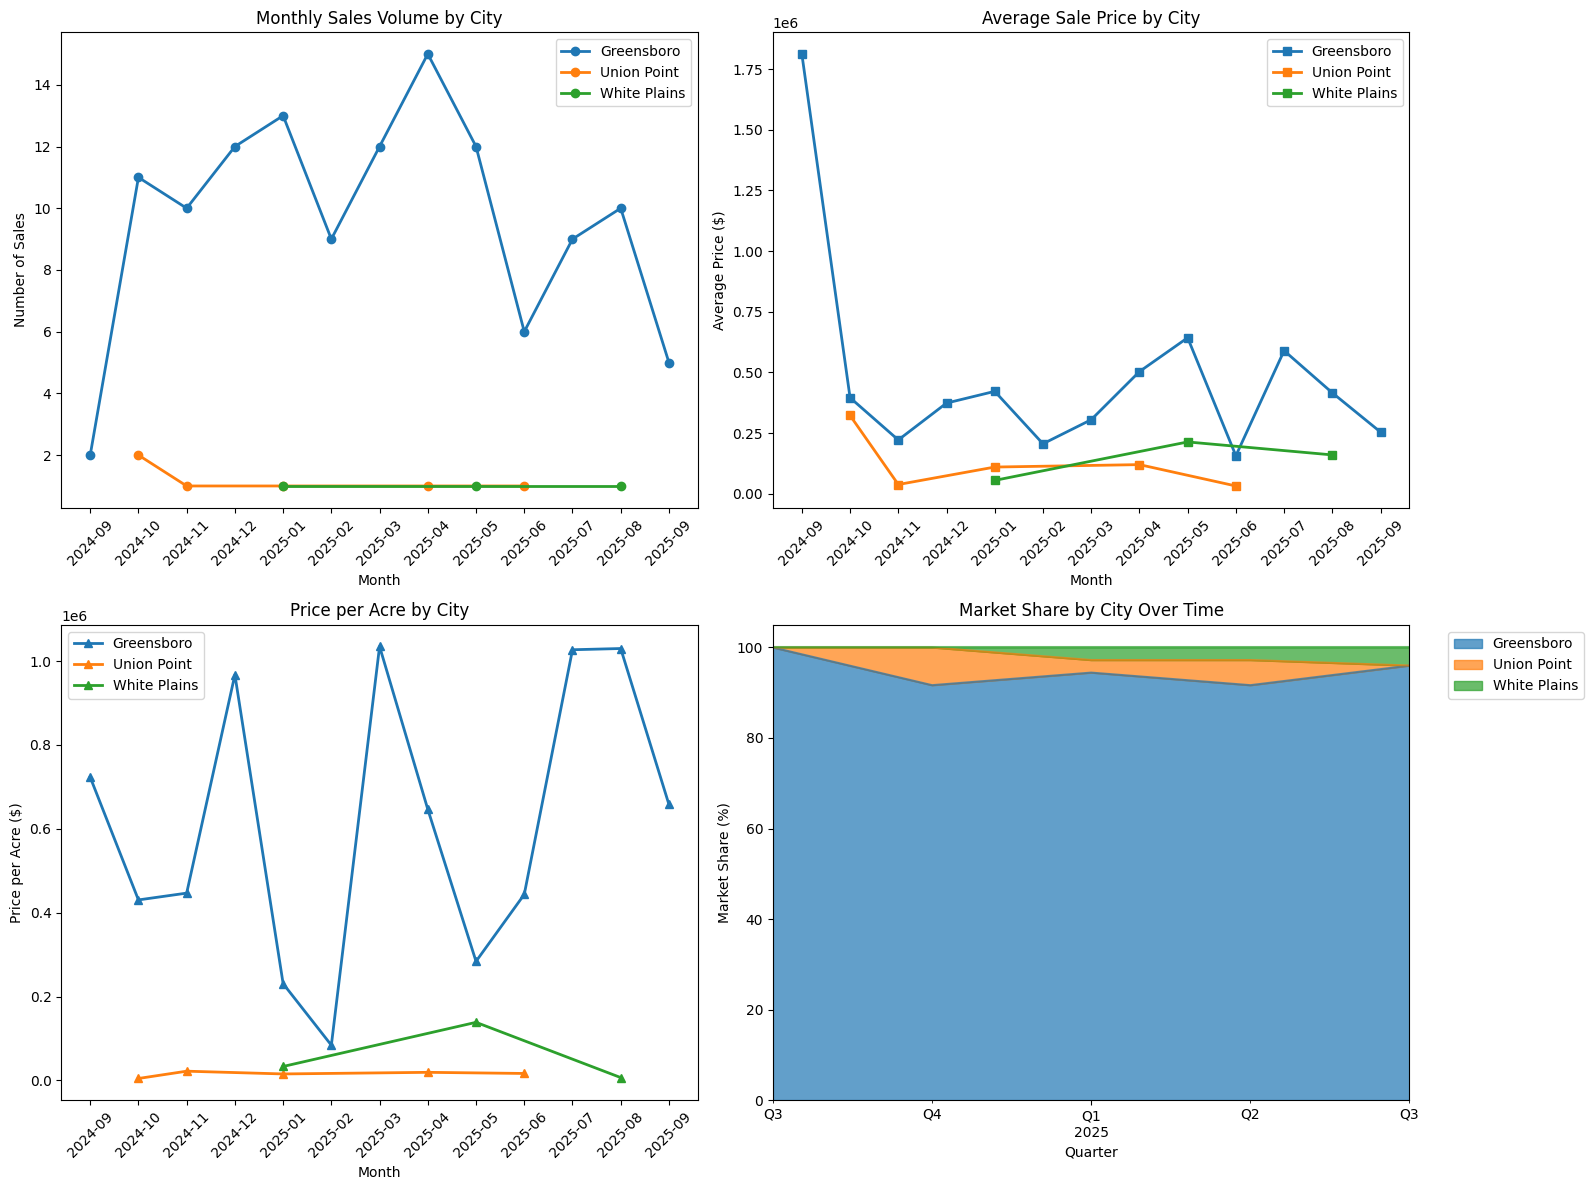

In [ ]:
# STEP 6: COMPREHENSIVE TREND AND PATTERN ANALYSIS

print("📈 STEP 6: COMPREHENSIVE MARKET ANALYSIS")
print("=" * 50)

print("We'll analyze:")
print("• Market trends over time (by city and area)")
print("• Pricing patterns and linearity")
print("• Anomalies and undervalued opportunities")
print("• Emerging market patterns")

# 1. TIME-BASED TREND ANALYSIS BY CITY
print("\n1. 📅 TIME-BASED TRENDS BY CITY")

# Ensure proper datetime format
df_spatial['sold_date'] = pd.to_datetime(df_spatial['sold_date'])
df_spatial['sold_month'] = df_spatial['sold_date'].dt.to_period('M')
df_spatial['sold_quarter'] = df_spatial['sold_date'].dt.to_period('Q')

print(f"Date range: {df_spatial['sold_date'].min().strftime('%Y-%m-%d')} to {df_spatial['sold_date'].max().strftime('%Y-%m-%d')}")

# Monthly trends by city
monthly_city_trends = df_spatial.groupby(['sold_month', 'city']).agg({
    'sale_price($)': ['count', 'mean', 'median'],
    'price_per_acre': 'mean',
    'lot_size_acres': 'mean'
}).round(2)

monthly_city_trends.columns = ['_'.join(col).strip() for col in monthly_city_trends.columns.values]
monthly_city_trends = monthly_city_trends.rename(columns={
    'sale_price($)_count': 'sales_count',
    'sale_price($)_mean': 'avg_price',
    'sale_price($)_median': 'median_price'
})

print("📊 MONTHLY TRENDS BY CITY:")
# Pivot for better visualization
monthly_pivot = monthly_city_trends.reset_index().pivot_table(
    index='sold_month', columns='city', values='avg_price', aggfunc='mean'
)
display(monthly_pivot.tail(10))  # Show last 10 months

# 2. VISUALIZE CITY TRENDS OVER TIME
print("\n2. 📊 VISUALIZING CITY TRENDS OVER TIME")

plt.figure(figsize=(16, 12))

# Plot 1: Sales volume by city over time
plt.subplot(2, 2, 1)
for city in df_spatial['city'].unique():
    city_data = monthly_city_trends.xs(city, level='city', drop_level=False) if city in monthly_city_trends.index.get_level_values(1) else None
    if city_data is not None and len(city_data) > 0:
        plt.plot(city_data.index.get_level_values(0).astype(str),
                city_data['sales_count'], marker='o', label=city, linewidth=2)
plt.title('Monthly Sales Volume by City')
plt.xlabel('Month')
plt.ylabel('Number of Sales')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('Monthly Sales Volume by City.png')


# Plot 2: Average price trends by city
plt.subplot(2, 2, 2)
for city in df_spatial['city'].unique():
    city_data = monthly_city_trends.xs(city, level='city', drop_level=False) if city in monthly_city_trends.index.get_level_values(1) else None
    if city_data is not None and len(city_data) > 0:
        plt.plot(city_data.index.get_level_values(0).astype(str),
                city_data['avg_price'], marker='s', label=city, linewidth=2)
plt.title('Average Sale Price by City')
plt.xlabel('Month')
plt.ylabel('Average Price ($)')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('Average Sale Price by City.png')


# Plot 3: Price per acre trends
plt.subplot(2, 2, 3)
for city in df_spatial['city'].unique():
    city_data = monthly_city_trends.xs(city, level='city', drop_level=False) if city in monthly_city_trends.index.get_level_values(1) else None
    if city_data is not None and len(city_data) > 0:
        plt.plot(city_data.index.get_level_values(0).astype(str),
                city_data['price_per_acre_mean'], marker='^', label=city, linewidth=2)
plt.title('Price per Acre by City')
plt.xlabel('Month')
plt.ylabel('Price per Acre ($)')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('Price per Acre by City.png')


# Plot 4: Market share by city over time
plt.subplot(2, 2, 4)
city_market_share = df_spatial.groupby(['sold_quarter', 'city']).size().unstack(fill_value=0)
city_market_share_pct = city_market_share.div(city_market_share.sum(axis=1), axis=0) * 100
city_market_share_pct.plot(kind='area', stacked=True, ax=plt.gca(), alpha=0.7)
plt.title('Market Share by City Over Time')
plt.xlabel('Quarter')
plt.ylabel('Market Share (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Market Share by City Over Time.png')


# 3. PRICING PATTERNS AND LINEARITY ANALYSIS
print("\n3. 📐 PRICING PATTERNS AND LINEARITY ANALYSIS")

from scipy.stats import pearsonr

print("🔍 CORRELATION ANALYSIS:")

# Correlation between lot size and price
corr_lot_price, p_value_lot = pearsonr(df_spatial['lot_size_acres'], df_spatial['sale_price($)'])
corr_lot_ppa, p_value_ppa = pearsonr(df_spatial['lot_size_acres'], df_spatial['price_per_acre'])

print(f"• Lot Size vs Total Price: r = {corr_lot_price:.3f} (p = {p_value_lot:.3f})")
print(f"• Lot Size vs Price/Acre: r = {corr_lot_ppa:.3f} (p = {p_value_ppa:.3f})")

# Interpret correlations
def interpret_correlation(r, relationship):
    if abs(r) < 0.3:
        return f"Weak correlation: {relationship} not strongly tied"
    elif abs(r) < 0.7:
        return f"Moderate correlation: Some relationship between {relationship}"
    else:
        return f"Strong correlation: {relationship} heavily dependent"

print(f"📈 INTERPRETATION:")
print(f"• {interpret_correlation(corr_lot_price, 'price and lot size')}")
print(f"• {interpret_correlation(corr_lot_ppa, 'price per acre and lot size')}")

# Price patterns by area type
print(f"\n🏙️ PRICE PATTERNS BY AREA TYPE:")
area_type_analysis = df_spatial.groupby('final_area_name').agg({
    'sale_price($)': ['count', 'mean', 'std'],
    'price_per_acre': ['mean', 'std'],
    'lot_size_acres': 'mean'
}).round(2)

area_type_analysis.columns = ['_'.join(col).strip() for col in area_type_analysis.columns.values]
area_type_analysis = area_type_analysis.rename(columns={'sale_price($)_count': 'listings_count'})

# Calculate price stability (lower std = more stable pricing)
area_type_analysis['price_stability'] = 1 / (1 + area_type_analysis['sale_price($)_std'] / area_type_analysis['sale_price($)_mean'])
area_type_analysis['value_consistency'] = 1 / (1 + area_type_analysis['price_per_acre_std'] / area_type_analysis['price_per_acre_mean'])

print("📊 AREA PRICE CHARACTERISTICS:")
display(area_type_analysis[['listings_count', 'sale_price($)_mean', 'price_per_acre_mean', 'price_stability', 'value_consistency']].sort_values('sale_price($)_mean', ascending=False))

# 4. ANOMALY DETECTION - UNDERVALUED OPPORTUNITIES
print("\n4. 🔍 ANOMALY DETECTION - UNDERVALUED OPPORTUNITIES")

# Method 1: Properties priced below area average
undervalued_properties = []

for area in df_spatial['final_area_name'].unique():
    area_data = df_spatial[df_spatial['final_area_name'] == area]
    if len(area_data) >= 3:  # Need enough data for meaningful comparison
        area_avg_ppa = area_data['price_per_acre'].mean()
        area_std_ppa = area_data['price_per_acre'].std()

        # Find properties significantly below area average
        undervalued_candidates = area_data[
            area_data['price_per_acre'] < (area_avg_ppa - 0.5 * area_std_ppa)  # 0.5 std below mean
        ]

        for idx, property_data in undervalued_candidates.iterrows():
            discount_pct = ((area_avg_ppa - property_data['price_per_acre']) / area_avg_ppa) * 100
            undervalued_properties.append({
                'address': property_data['address'],
                'area': area,
                'city': property_data['city'],
                'sale_price': property_data['sale_price($)'],
                'price_per_acre': property_data['price_per_acre'],
                'area_avg_ppa': area_avg_ppa,
                'discount_pct': discount_pct,
                'lot_size': property_data['lot_size_acres']
            })

# Convert to DataFrame
undervalued_df = pd.DataFrame(undervalued_properties)

print(f"💰 UNDERVALUED PROPERTIES FOUND: {len(undervalued_df)}")

if len(undervalued_df) > 0:
    print("\n🏆 TOP UNDERVALUED OPPORTUNITIES (by discount %):")
    top_opportunities = undervalued_df.nlargest(10, 'discount_pct')[['address', 'area', 'city', 'sale_price', 'price_per_acre', 'area_avg_ppa', 'discount_pct', 'lot_size']]
    display(top_opportunities.round(2))
else:
    print("No significantly undervalued properties detected")

# 5. EMERGING MARKET PATTERNS
print("\n5. 🌟 EMERGING MARKET PATTERNS")

# Analyze recent vs historical trends
recent_cutoff = df_spatial['sold_date'].max() - pd.Timedelta(days=120)  # Last 120 days
recent_sales = df_spatial[df_spatial['sold_date'] >= recent_cutoff]
older_sales = df_spatial[df_spatial['sold_date'] < recent_cutoff]

print("📊 RECENT VS HISTORICAL MARKET COMPARISON:")

if len(recent_sales) > 0 and len(older_sales) > 0:
    comparison_data = []

    for city in df_spatial['city'].unique():
        city_recent = recent_sales[recent_sales['city'] == city]
        city_older = older_sales[older_sales['city'] == city]

        if len(city_recent) > 0 and len(city_older) > 0:
            recent_avg = city_recent['sale_price($)'].mean()
            older_avg = city_older['sale_price($)'].mean()
            price_change = ((recent_avg - older_avg) / older_avg) * 100

            recent_volume = len(city_recent)
            older_volume = len(city_older)
            volume_change = ((recent_volume - older_volume) / older_volume) * 100 if older_volume > 0 else float('inf')

            comparison_data.append({
                'city': city,
                'recent_sales': recent_volume,
                'historical_sales': older_volume,
                'volume_change_pct': volume_change,
                'recent_avg_price': recent_avg,
                'historical_avg_price': older_avg,
                'price_change_pct': price_change
            })

    comparison_df = pd.DataFrame(comparison_data).round(2)
    print("📈 CITY-BY-CITY MARKET MOMENTUM:")
    display(comparison_df)

    # Identify emerging trends
    print("\n🚀 EMERGING MARKET INSIGHTS:")
    for _, row in comparison_df.iterrows():
        if row['price_change_pct'] > 10:
            print(f"• {row['city']}: 🚀 BOOMING - Prices up {row['price_change_pct']:.1f}%")
        elif row['price_change_pct'] > 5:
            print(f"• {row['city']}: 📈 GROWING - Prices up {row['price_change_pct']:.1f}%")
        elif row['price_change_pct'] < -5:
            print(f"• {row['city']}: 📉 COOLING - Prices down {abs(row['price_change_pct']):.1f}%")
        else:
            print(f"• {row['city']}: ➡️ STABLE - Prices changed {row['price_change_pct']:.1f}%")

        if row['volume_change_pct'] > 20:
            print(f"  📊 Market activity: HIGH (volume up {row['volume_change_pct']:.1f}%)")
else:
    print("Insufficient recent data for trend comparison")

# 6. SEASONALITY ANALYSIS
print("\n6. 📅 SEASONALITY PATTERNS")

df_spatial['sold_month_num'] = df_spatial['sold_date'].dt.month
monthly_patterns = df_spatial.groupby('sold_month_num').agg({
    'sale_price($)': ['count', 'mean'],
    'price_per_acre': 'mean'
}).round(2)

monthly_patterns.columns = ['_'.join(col).strip() for col in monthly_patterns.columns.values]
monthly_patterns = monthly_patterns.rename(columns={
    'sale_price($)_count': 'sales_count',
    'sale_price($)_mean': 'avg_price'
})

print("📊 MONTHLY SEASONALITY PATTERNS:")
display(monthly_patterns)

# Identify seasonal trends
if len(monthly_patterns) >= 6:  # Need at least 6 months of data
    high_season = monthly_patterns['sales_count'].idxmax()
    low_season = monthly_patterns['sales_count'].idxmin()

    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    print(f"• Peak season: {month_names[high_season-1]} (avg {monthly_patterns.loc[high_season, 'sales_count']:.1f} sales)")
    print(f"• Low season: {month_names[low_season-1]} (avg {monthly_patterns.loc[low_season, 'sales_count']:.1f} sales)")

print("\n✅ COMPREHENSIVE MARKET ANALYSIS COMPLETE!")
print("📋 SUMMARY OF KEY FINDINGS:")
print("• Time-based trends by city identified")
print("• Pricing patterns and correlations analyzed")
print("• Undervalued opportunities highlighted")
print("• Emerging market patterns detected")
print("• Seasonality patterns examined")
print("• Ready for final Landcurator report!")

## Exporting Charts to Images

You can save the charts generated by matplotlib as image files. Here's how you can do it for a plot:

After creating a plot using `matplotlib.pyplot` (usually ending with `plt.show()`), you can save it using `plt.savefig()`.

**Steps:**

1.  **Add `plt.savefig()`:** Immediately *before* `plt.show()`, add a line `plt.savefig('your_chart_name.png')`.
2.  **Specify Filename and Format:** Replace `'your_chart_name.png'` with the desired filename. You can change the file extension to save in different formats (e.g., `.png`, `.jpg`, `.svg`, `.pdf`). PNG is generally good for documents.
3.  **Run the Cell:** Execute the code cell containing the plot. The plot will be displayed, and an image file will be saved in your Colab environment's file system.
4.  **Download the Image:** In the Colab file browser (the folder icon on the left sidebar), find the image file you saved. Right-click on the file and select "Download".
5.  **Insert into Document:** Open your Word document and insert the downloaded image file.

**Example Modification:**

Let's take the geographic distribution plot from cell `9fUSX0MtnL0H` as an example. The original code ends with `plt.tight_layout()` and `plt.show()`. You would modify it like this:

In [ ]:
# Define the list of columns to save for QGIS
qgis_columns = [
    'address',
    'city',
    'state',
    'zip_code',
    'latitude',
    'longitude',
    'sale_price($)',
    'lot_size_acres',
    'price_per_acre',
    'final_area_name',
    # 'cluster_label_final', # Removed as requested
    'sold_date'
]

# Create a new DataFrame with only the selected columns
# Make a copy to avoid SettingWithCopyWarning when adding new columns
df_qgis = df_spatial[qgis_columns].copy()

# Calculate quantile-based price tier and undervalued flag
# Adding these columns directly to df_qgis for the QGIS export
df_qgis['price_tier'] = pd.qcut(df_qgis['sale_price($)'], q=4, labels=['Budget', 'Mid-Range', 'Premium', 'Luxury'])
df_qgis['undervalued_flag'] = df_qgis['price_per_acre'] < df_qgis['price_per_acre'].quantile(0.25)

# Add the new columns to the list of columns saved for QGIS
# Note: These were added directly to df_qgis, so they are included automatically
# qgis_columns.append('price_tier') # No need to append, they are added to df_qgis directly
# qgis_columns.append('undervalued_flag') # No need to append

# Save the new DataFrame to a CSV file
df_qgis.to_csv('greene_county_land_sales_for_qgis.csv', index=False)

print(f"Saved the selected columns, including 'price_tier' and 'undervalued_flag', to 'greene_county_land_sales_for_qgis.csv'")
print("\nColumns saved for QGIS:")
print(df_qgis.columns)

Saved the selected columns, including 'price_tier' and 'undervalued_flag', to 'greene_county_land_sales_for_qgis.csv'

Columns saved for QGIS:
Index(['address', 'city', 'state', 'zip_code', 'latitude', 'longitude',
       'sale_price($)', 'lot_size_acres', 'price_per_acre', 'final_area_name',
       'sold_date', 'price_tier', 'undervalued_flag'],
      dtype='object')


In [ ]:
# Save the cleaned and analyzed dataframe to a new CSV file
df_spatial.to_csv('greene_county_land_sales_analyzed.csv', index=False)

print("Saved the analyzed data to 'greene_county_land_sales_analyzed.csv'")

Saved the analyzed data to 'greene_county_land_sales_analyzed.csv'


In [ ]:
# Display the column names
print("DataFrame columns:")
print(df_spatial.columns)

DataFrame columns:
Index(['address', 'city', 'state', 'zip_code', 'property_type',
       'lot_size_sqft', 'sold_date', 'sale_price($)', 'lot_size_acres',
       'latitude', 'longitude', 'price_per_acre', 'cluster', 'cluster_label',
       'cluster_optimal', 'cluster_label_optimal', 'sold_month', 'sold_year',
       'cluster_final', 'cluster_label_final', 'geo_cluster',
       'neighborhood_name', 'area_cluster', 'area_name', 'manual_cluster',
       'final_area_name', 'sold_quarter', 'sold_month_num'],
      dtype='object')
